<a href="https://colab.research.google.com/github/bernardes7/Paredes/blob/main/notebooks/Between_Voices_Main(preprocessed_notes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Between Voices — Colab Notebook:
- **Structural**: Annotations (beats, sections, phrases)
- **Rhythmic**: BPM series, tempo deviations (anchored to median BPM from Section 2), onset peak counts per beat
- **Harmonic**: NNLS chromas, TIVs, TIV qualities, dissonance and dispersion, Harmonic Change Function (frames & beats)
- **Melodic**: Beat-sync spectral centroids on CQT Spectra for voice and guitars
- **Dynamic**: RMS-based loudness (dB) per beat

> **Export rule**: The final JSON contains **raw values only** for all series **except chromas** (which remain the usual normalized/thresheld representations).


## 1) Environment Setup & Imports



In [1]:
%%capture
%pip install -q "numpy>=2.0,<2.3" "scipy>=1.14" "pandas>=2.2" librosa==0.11.0 ipywidgets PyPDF2 dissonant
!git clone -q https://github.com/aframires/TIVlib.git /content/TIVlib
%pip install -q PyMuPDF
%pip install EMD-signal
%pip install fastdtw


import sys, os, math, glob, re, json, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
from scipy.ndimage import gaussian_filter1d, median_filter, convolve, convolve1d
from scipy.signal import find_peaks
from scipy.optimize import nnls
from scipy.stats import zscore
from IPython.display import Audio, display
import seaborn as sns
from PyEMD import EMD
import fitz
from google.colab import files, drive
import itertools
from collections import Counter
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.collections import LineCollection
import ipywidgets as widgets
from dissonant import dissonance


sys.path.insert(0, '/content/TIVlib')
from TIVlib import TIV as tiv

## 2) Utilities, Configuration

In [3]:
# --- Select Project by Uncommenting One Line ---
# PROJECT_NAME = '1958_Augusto Camacho/Quando os Sinos Dobram'
# PROJECT_NAME = '1958_Augusto Camacho/Adeus a Coimbra'
# PROJECT_NAME = '1958_Augusto Camacho/Água da Fonte'
# PROJECT_NAME = '1958_Augusto Camacho/A Luz do Teu Olhar'
# PROJECT_NAME = '1970_Cecília de Melo/Não Choro por me Deixares'
# PROJECT_NAME = '1970_Cecília de Melo/O Render dos Heróis'
# PROJECT_NAME = '1967_Luiz Goes/Balada do Mar'
PROJECT_NAME = '1967_Luiz Goes/Canção da Infância'

# Utilities

# Create Log and Plot Containers
LOG_FILE = "./execution_log.txt"
PLOT_DIR = "./saved_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Clear previous plots
for file_name in os.listdir(PLOT_DIR):
    file_path = os.path.join(PLOT_DIR, file_name)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(f"Error deleting file {file_path}: {e}")


# Clear the log file at the beginning of the run
with open(LOG_FILE, "w") as f:
    f.write("") # Write an empty string to clear the file

# Log messages for Final Report
def log_message(message):
    print(message)
    with open(LOG_FILE, "a") as f:
        f.write(message + "\n")

# Numerical array to list
def _nan_to_none_list(arr):
    out = []
    for v in np.asarray(arr, dtype=float):
        out.append(float(v) if np.isfinite(v) else None)
    return out

# Cosine Distance
def cosine_distance_complex(vec1, vec2):
    dot_product = np.vdot(vec1, vec2)
    n1 = np.linalg.norm(vec1)
    n2 = np.linalg.norm(vec2)
    if n1 < 1e-12 or n2 < 1e-12:
        return 1.0
    cos_sim = np.real(dot_product) / (n1 * n2)
    cos_sim = np.clip(cos_sim, -1.0, 1.0)
    return 1.0 - cos_sim

# Extracts TIV objects to NumPy arrays
def extract_tiv_vector(tiv_obj):
    if tiv_obj is None:
        return None
    if hasattr(tiv_obj, 'vector'):
        return np.array(tiv_obj.vector)
    elif isinstance(tiv_obj, (np.ndarray, list, tuple)):
        return np.array(tiv_obj)
    raise ValueError(f"Unsupported TIV type: {type(tiv_obj)}")

def call_tiv_method_safe(tiv_obj, method_name):
    if tiv_obj is None:
        return np.nan
    method = getattr(tiv_obj, method_name, None)
    if callable(method):
        try:
            return method()
        except Exception:
            return np.nan
    return np.nan

# Aggregates Frames to Beats
def aggregate_to_beats(frame_times, values, beat_times, pad_last=False):
    n_beats = len(beat_times) - 1
    out = []
    for b in range(n_beats):
        t0, t1 = beat_times[b], beat_times[b+1]
        idx = np.where((frame_times >= t0) & (frame_times < t1))[0]
        out.append(np.mean(values[idx]) if len(idx) > 0 else np.nan)
    if pad_last:
        out.append(out[-1] if len(out) > 0 else np.nan)
    return np.asarray(out)

# Centralized masking function
def apply_mask(data, mask):
    import numpy as np
    return np.where(mask, np.nan, data)


# DSP Parameters
n_fft = 2048
hop_length = 512
window = 'hann'

# CQT / Chroma
bins_per_octave = 36
n_octaves = 5
cqt_normalize = False
cqt_norm_type = 'max'
cqt_denoise_median = None

# NNLS dictionary (best-performing configuration)
s = 0.5                 # optimized harmonic decay
apply_whitening = True  # whitening ON
chroma_threshold = 0.02 # keep as in your pipeline (works well)


# HCF
hcf_method = 'tiv_full'  # or '3_5_phases'

# Sensory dissonance
N_partials = 60

# Define onset parameters
track_params = {
    'Vocals': {
        'min_peak_distance_s': 0.25,
        'threshold_std': 1.2,
        'prominence_factor': 1.0
    },
    'Guitars': {
        'min_peak_distance_s': 0.08,
        'threshold_std': 0.3,
        'prominence_factor': 0.5
    },
    'Full': {
        'min_peak_distance_s': 0.05,
        'threshold_std': 0.5,
        'prominence_factor': 0.4
    }
}

# Data path
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/Between Voices/Corpus de Colaborações'

GOOGLE_DRIVE_DATA_PATH = os.path.join(BASE_DIR, PROJECT_NAME)
full_audio_path  = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'full_audio.m4a')
guitars_path     = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'guitars.wav')
vocals_path      = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'voice.wav')
beats_path       = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'beats.txt')
chords_path      = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'chords.txt')
phrases_path     = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'phrases.txt')
sections_path    = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'sections.txt')
notes_path       = os.path.join(GOOGLE_DRIVE_DATA_PATH, 'notes.txt')

print("GOOGLE_DRIVE_DATA_PATH =", GOOGLE_DRIVE_DATA_PATH)
print("Assuming files at:")
for p in [full_audio_path, guitars_path, vocals_path, beats_path, notes_path, chords_path, phrases_path, sections_path]:
    print(" -", p, "exists:", os.path.exists(p))


Mounted at /content/drive
GOOGLE_DRIVE_DATA_PATH = /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância
Assuming files at:
 - /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância/full_audio.m4a exists: True
 - /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância/guitars.wav exists: True
 - /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância/voice.wav exists: True
 - /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância/beats.txt exists: True
 - /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância/notes.txt exists: True
 - /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância/chords.txt exists: True
 - /content/drive/MyDrive/Between Voices/Corpus de Colaborações/1967_Luiz Goes/Canção da Infância/phr

## 3) Structural — Load Annotations

In [4]:
# Audio loader
def load_audio_file(file_path, sr=None):
    if os.path.exists(file_path):
        y_loaded, sr_loaded = librosa.load(file_path, sr=sr)
        y_loaded = np.nan_to_num(y_loaded, nan=0.0, posinf=0.0, neginf=0.0)
        print(f"Loaded {os.path.basename(file_path)} @ {sr_loaded} Hz, duration {len(y_loaded)/sr_loaded:.2f}s")
        return y_loaded, sr_loaded
    print(f"Warning: file not found: {file_path}")
    return None, None

y_full, sr_full = load_audio_file(full_audio_path, sr=None)
y_guitars, sr_guitars = load_audio_file(guitars_path, sr=None)
y_vocals, sr_vocals = load_audio_file(vocals_path, sr=None)

valid_srs = [s for s in [sr_full, sr_guitars, sr_vocals] if s is not None]
if len(valid_srs)==0:
    raise RuntimeError('No audio loaded')
if not all(s==valid_srs[0] for s in valid_srs):
    raise RuntimeError(f"Sample rate mismatch: {sr_full, sr_guitars, sr_vocals}")
sr = valid_srs[0]

# Beats
if os.path.exists(beats_path):
    df_beats = pd.read_csv(beats_path, sep='	', header=None, names=['Beat_Time_Seconds','Metrical_Position'])
    beat_times = df_beats['Beat_Time_Seconds'].values
else:
    raise FileNotFoundError(beats_path)

# Notes
if os.path.exists(notes_path):
    df_notes = pd.read_csv(notes_path, sep='	', header=None, names=['Note_onset','Note_duration','Frequency'])
else:
    raise FileNotFoundError(beats_path)

# Sections / Phrases
df_sections = pd.read_csv(sections_path, sep='	', header=None, names=['Initial_Time','Track','Duration','Label'])
df_phrases  = pd.read_csv(phrases_path,  sep='	', header=None, names=['Initial_Time','Track','Duration','Label'])

# Chords
if os.path.exists(chords_path):
    df_chords = pd.read_csv(chords_path, sep='	', header=None, names=['Chord_Times_Seconds','Chord_Type'])
    chord_times_seconds = df_chords['Chord_Times_Seconds'].values
    chord_types = df_chords['Chord_Type'].values
else:
    df_chords = None
    chord_times_seconds = None
    chord_types = None


/tmp/ipython-input-1495042608.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y_loaded, sr_loaded = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Loaded full_audio.m4a @ 44100 Hz, duration 145.59s
Loaded guitars.wav @ 44100 Hz, duration 145.59s
Loaded voice.wav @ 44100 Hz, duration 145.59s


## 4) Harmonic — Preprocess, Chroma, TIVs, HCF

In [5]:
from scipy.optimize import nnls
from scipy.ndimage import convolve1d

def nnls_chroma_ptg(y, sr):
    """NNLS-based chroma: WHI+DEC+ODD+RES, INH & MED OFF"""
    A0 = librosa.note_to_hz('A0')
    C = np.abs(librosa.cqt(y, sr=sr, hop_length=hop_length, bins_per_octave=bins_per_octave,
                           n_bins=bins_per_octave * n_octaves, fmin=A0)).astype(np.float32)
    freqs = librosa.cqt_frequencies(C.shape[0], fmin=A0, bins_per_octave=bins_per_octave)

    if cqt_normalize:
        C = C / np.maximum(C.max(axis=0, keepdims=True) if cqt_norm_type == 'max' else np.linalg.norm(C, axis=0, keepdims=True), 1e-8)

    if apply_whitening:
        win_len = int(round(0.5 * bins_per_octave))
        if win_len % 2 == 0: win_len += 1
        kernel = np.hamming(win_len).astype(np.float32)
        kernel /= kernel.sum()
        mu = convolve1d(C, kernel, axis=0, mode='reflect')
        var = convolve1d((C - mu)**2, kernel, axis=0, mode='reflect')
        C = np.maximum((C - mu) / np.maximum(np.sqrt(var), 1e-8), 0.0).astype(np.float32)

    s, odd_boost, res_gain_scale = 0.5, 0.95, 1.4
    body_resonances = [(120.0, 30.0, 0.9*res_gain_scale), (470.0, 80.0, 0.7*res_gain_scale), (1000.0, 150.0, 0.5*res_gain_scale)]
    spread_semitones, max_harmonics = 0.35, 20

    bin_semitone_pos = np.log2(freqs / A0) * 12.0
    note_freqs = librosa.midi_to_hz(np.arange(21, 21 + n_octaves * 12))
    E = np.zeros((len(freqs), len(note_freqs)), dtype=np.float32)

    for j, f0 in enumerate(note_freqs):
        col = np.zeros(len(freqs), dtype=np.float32)
        for k in range(1, max_harmonics + 1):
            fk = f0 * k
            if fk > freqs[-1] * 1.001: break
            ak = (s ** (k - 1)) * (odd_boost if (k % 2) == 1 else 1.0)
            diff = bin_semitone_pos - np.log2(fk / A0) * 12.0
            col += (ak * np.exp(-0.5 * (diff**2) / (spread_semitones**2))).astype(np.float32)
        nrm = np.linalg.norm(col)
        if nrm > 0: col /= nrm
        E[:, j] = col

    body_gain = np.ones(len(freqs), dtype=np.float32)
    for f_res, width_hz, gain in body_resonances:
        body_gain += gain * np.exp(-0.5 * ((freqs - f_res)**2) / (width_hz**2)).astype(np.float32)
    E *= body_gain[:, None]
    for j in range(E.shape[1]):
        nrm = np.linalg.norm(E[:, j])
        if nrm > 0: E[:, j] /= nrm

    semitone_acts = np.zeros((len(note_freqs), C.shape[1]), dtype=np.float32)
    for t in range(C.shape[1]):
        x, _ = nnls(E, C[:, t])
        semitone_acts[:, t] = x

    midi_numbers = np.arange(21, 21 + len(note_freqs))
    pcs = midi_numbers % 12
    chroma = np.zeros((12, semitone_acts.shape[1]), dtype=np.float32)
    for j, pc in enumerate(pcs):
        chroma[pc, :] += semitone_acts[j, :]

    chroma /= np.maximum(chroma.max(axis=0, keepdims=True), 1e-8)
    if chroma_threshold > 0:
        chroma[chroma < chroma_threshold] = 0.0
    return chroma

def hcf_raw_from_tivs(tiv_vectors, method='tiv_full'):
    if tiv_vectors is None or len(tiv_vectors) == 0: return np.array([])
    Tv = np.array(tiv_vectors)
    if Tv.ndim != 2: raise ValueError('TIV array must be 2D')
    if Tv.shape[0] < Tv.shape[1] and Tv.shape[0] != 6: Tv = Tv.T
    D, T = Tv.shape
    Tv_pad = np.column_stack([np.zeros(D, dtype=Tv.dtype), Tv, np.zeros(D, dtype=Tv.dtype)])

    if method == 'tiv_full':
        diff = Tv_pad[:, 2:] - Tv_pad[:, :-2]
        return np.linalg.norm(diff, axis=0)
    elif method == '3_5_phases':
        vals = []
        for i in range(T):
            v1, v2 = Tv_pad[[2, 4], i], Tv_pad[[2, 4], i+2]
            n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
            if n1 < 1e-9 or n2 < 1e-9:
                vals.append(1.0)
            else:
                sim = np.abs(np.vdot(v1, v2)) / (n1 * n2)
                vals.append(np.clip(1.0 - sim, 0.0, 1.0))
        return np.asarray(vals)
    else:
        raise ValueError('Invalid hcf_method')

# HPSS
y_harmonic, y_percussive = librosa.effects.hpss(y_guitars, margin=(1.0, 6.0), power=2.0)

# Initialize variables
chroma_frames = None
frame_times = None
chroma_beats = None
tiv_beats_objs = []
tiv_beats = np.array([])
hcf_raw_beats = np.array([])
tiv_frames_objs = []
tiv_frames = np.array([])
hcf_raw_frames = np.array([])
global_chroma_beats_all = np.zeros(12)
global_chroma_beats_sec2 = np.zeros(12)
key_global = "C:maj"
key_section2 = "C:maj"
df_qualities = pd.DataFrame()

# Process if harmonic audio exists
if y_harmonic is not None:
    chroma_frames = nnls_chroma_ptg(y_harmonic, sr)
    frame_times = librosa.frames_to_time(np.arange(chroma_frames.shape[1]), sr=sr, hop_length=hop_length)

    # Beat-sync chroma
    n_beats = len(beat_times) - 1
    chroma_beats = np.zeros((12, n_beats), dtype=np.float32)
    for b in range(n_beats):
        t0, t1 = beat_times[b], beat_times[b+1]
        idx = np.where((frame_times >= t0) & (frame_times < t1))[0]
        if len(idx) > 0:
            chroma_beats[:, b] = np.median(chroma_frames[:, idx], axis=1)

    chroma_beats /= np.maximum(chroma_beats.max(axis=0, keepdims=True), 1e-8)
    if chroma_threshold > 0:
        chroma_beats[chroma_beats < chroma_threshold] = 0.0

    # Global chromas
    global_chroma_beats_all = np.sum(chroma_beats, axis=1)

    if df_sections is not None and len(df_sections) > 1:
        sec2 = df_sections.iloc[1]
        sec2_start, sec2_end = sec2['Initial_Time'], sec2['Initial_Time'] + sec2['Duration']
        beat_times_eff = beat_times[:chroma_beats.shape[1]]
        mask_b = (beat_times_eff >= sec2_start) & (beat_times_eff < sec2_end)
        if np.any(mask_b):
            global_chroma_beats_sec2 = np.sum(chroma_beats[:, mask_b], axis=1)

    key_global = tiv.key(tiv.from_pcp(global_chroma_beats_all), mode="Shaath")
    key_section2 = tiv.key(tiv.from_pcp(global_chroma_beats_sec2), mode="Shaath")

    log_message(f"Key (Global - All Beats): {key_global}")
    log_message(f"Key (Section 2 Only): {key_section2}")
    log_message("-" * 20)

    # TIVs and HCF
    tiv_beats_objs = [tiv.from_pcp(chroma_beats[:, i]) for i in range(chroma_beats.shape[1])]
    tiv_beats = np.array([obj.vector for obj in tiv_beats_objs])
    hcf_raw_beats = hcf_raw_from_tivs(tiv_beats.T, hcf_method)

    tiv_frames_objs = [tiv.from_pcp(chroma_frames[:, i]) for i in range(chroma_frames.shape[1])]
    tiv_frames = np.array([obj.vector for obj in tiv_frames_objs])
    hcf_raw_frames = hcf_raw_from_tivs(tiv_frames.T, hcf_method)

    # Tonal qualities
    global_tiv_beats = tiv.from_pcp(global_chroma_beats_all)
    gvec = extract_tiv_vector(global_tiv_beats)
    quality_data = []
    for tobj in tiv_beats_objs:
        tv = extract_tiv_vector(tobj)
        disp = cosine_distance_complex(gvec, tv)
        quality_data.append({
            'Chromaticity': call_tiv_method_safe(tobj, 'chromaticity'),
            'Diatonicity': call_tiv_method_safe(tobj, 'diatonicity'),
            'Dyadicity': call_tiv_method_safe(tobj, 'dyadicity'),
            'Triadicity': call_tiv_method_safe(tobj, 'triadicity'),
            'Dim_Quality': call_tiv_method_safe(tobj, 'dim_quality'),
            'Wholetoneness': call_tiv_method_safe(tobj, 'wholetoneness'),
            'Tonal_Dissonance': call_tiv_method_safe(tobj, 'dissonance'),
            'Tonal_Dispersion': disp,
        })
    df_qualities = pd.DataFrame(quality_data)

Key (Global - All Beats): ('d', 'min')
Key (Section 2 Only): ('d', 'min')
--------------------


## 5) Melodic and Harmonic Contour

In [6]:
import librosa
import numpy as np

def spectral_centroid_frames(y, sr, n_fft, hop_length, window='hann'):
    """
    Compute spectral centroid using CQT instead of STFT.
    Returns time (ft) and centroid in MIDI (cent_midi).
    """
    # CQT parameters
    fmin = librosa.note_to_hz('C1')  # lowest frequency
    n_bins = 84                      # 7 octaves
    bins_per_octave = 12             # semitone resolution

    # Compute magnitude of CQT
    cqt = np.abs(librosa.cqt(y, sr=sr, hop_length=hop_length, fmin=fmin,
                             n_bins=n_bins, bins_per_octave=bins_per_octave))

    # Frequencies corresponding to each bin
    freqs = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)

    # Compute weighted spectral centroid (Hz)
    numerator = np.sum(cqt * freqs[:, np.newaxis], axis=0)
    denominator = np.sum(cqt, axis=0)
    cent = numerator / (denominator + 1e-6)  # avoid division by zero

    # Convert to MIDI
    cent_midi = librosa.hz_to_midi(cent)

    # Time axis
    ft = librosa.frames_to_time(np.arange(len(cent_midi)), sr=sr, hop_length=hop_length)

    return ft, cent_midi

# Aplicação
ft_v, cent_v = spectral_centroid_frames(y_vocals, sr, n_fft, hop_length, window)
ft_g, cent_g = spectral_centroid_frames(y_harmonic, sr, n_fft, hop_length, window)

melodic_centroid_raw  = aggregate_to_beats(ft_v, cent_v, beat_times)
harmonic_centroid_raw = aggregate_to_beats(ft_g, cent_g, beat_times)

## 6) Rhythmic — BPM, Tempo Deviations & Rhythmic Density

In [7]:
def compute_bpm_deviation_series(df_beats, df_sections, beat_times):
    beat_times = np.asarray(df_beats['Beat_Time_Seconds'].values, dtype=float)
    if beat_times.size < 2:
        raise ValueError('Need at least 2 beats to compute BPM')

    ibi = np.diff(beat_times)
    valid = ibi > 1e-9
    bpms_raw = np.full_like(ibi, np.nan, dtype=float)
    bpms_raw[valid] = 60.0 / ibi[valid]
    bpm_times = beat_times[:-1]

    median_bpm = np.nan
    if df_sections is not None and len(df_sections) >= 2:
        sec2 = df_sections.iloc[1]
        s0, s1 = float(sec2['Initial_Time']), float(sec2['Initial_Time']) + float(sec2['Duration'])
        mask = (bpm_times >= s0) & (bpm_times < s1)
        pool = bpms_raw[mask & np.isfinite(bpms_raw)]
        if pool.size >= 1:
            median_bpm = float(np.nanmedian(pool))

    if not np.isfinite(median_bpm):
        pool = bpms_raw[np.isfinite(bpms_raw)]
        median_bpm = float(np.nanmedian(pool)) if pool.size > 0 else np.nan

    bpm_diff_raw = bpms_raw - median_bpm if np.isfinite(median_bpm) else np.zeros_like(bpms_raw)
    subdiv_beats = np.asarray(beat_times[:len(bpm_diff_raw)], dtype=float)

    if bpm_times.size == 0:
        bpm_diff_aligned_raw = np.zeros_like(subdiv_beats)
    else:
        idx = np.searchsorted(bpm_times, subdiv_beats, side='right') - 1
        idx = np.clip(idx, 0, len(bpm_diff_raw) - 1)
        bpm_diff_aligned_raw = bpm_diff_raw[idx]

    # Log data
    median_bpm_display = f"{median_bpm:.2f}" if np.isfinite(median_bpm) else "NaN"
    log_message(f"Computed median BPM: {median_bpm_display}")
    log_message("-" * 20)

    return {
        'beat_times': beat_times,
        'bpm_times': bpm_times,
        'bpms_raw': bpms_raw,
        'median_bpm': median_bpm,
        'bpm_diff_raw': bpm_diff_raw,
        'bpm_diff_aligned_raw': bpm_diff_aligned_raw
    }

bpm_series = compute_bpm_deviation_series(df_beats, df_sections, df_beats['Beat_Time_Seconds'].values)
bpm_diff_raw = bpm_series['bpm_diff_raw']
bpm_diff_aligned_raw = bpm_series['bpm_diff_aligned_raw']


# --- Spectral flux computation ---
def compute_flux(y_input, sr, hop_length, n_fft):
    S = np.abs(librosa.stft(y_input, n_fft=n_fft, hop_length=hop_length))
    S /= (np.max(S) + 1e-8)
    flux = np.sqrt(np.sum(np.diff(S, axis=1, append=np.zeros((S.shape[0], 1)))**2, axis=0))
    times = librosa.frames_to_time(np.arange(len(flux)), sr=sr, hop_length=hop_length)
    return flux, times

def detect_peaks_from_flux(flux, sr, hop_length,
                           min_peak_distance_s=0.08,  # 80 ms
                           threshold_std=0.5,
                           prominence_factor=0.25):
    if len(flux) == 0:
        return np.array([], dtype=int), {}

    # Compute thresholds
    median_flux = np.median(flux)
    std_flux = np.std(flux)
    height_thr = median_flux + threshold_std * std_flux
    prominence_thr = max(1e-8, prominence_factor * std_flux)

    # Convert min distance in seconds to frames
    frame_rate = sr / hop_length
    min_dist_frames = max(1, int(round(min_peak_distance_s * frame_rate)))

    # Initial peak detection
    peaks, props = find_peaks(flux, height=height_thr,
                               distance=min_dist_frames,
                               prominence=prominence_thr)

    # Remove duplicates that are too close (for guitars only; vocals won't use this path)
    if len(peaks) > 1:
        filtered_peaks = [peaks[0]]
        for p in peaks[1:]:
            if (p - filtered_peaks[-1]) >= min_dist_frames:
                filtered_peaks.append(p)
        peaks = np.array(filtered_peaks)

    return peaks, props

# --- Helper: read vocal onsets from df_notes without de-duplication ---
def get_vocal_onsets_from_df(df_notes,
                             col='Note_onset',
                             t_max=None,
                             sort_times=True,
                             remove_negative=True,
                             remove_nans=True):
    """
    Read vocal note onset times (in seconds) from a DataFrame column.
    - Optionally removes NaNs and negative values
    - Optionally sorts the times
    - Optionally clamps to t_max (audio duration)
    No de-duplication is performed.
    """
    if df_notes is None or col not in df_notes.columns:
        raise ValueError(f"df_notes must contain a '{col}' column with onset times in seconds.")

    ptimes = df_notes[col].to_numpy(dtype=float)

    if remove_nans:
        ptimes = ptimes[np.isfinite(ptimes)]
    if remove_negative:
        ptimes = ptimes[ptimes >= 0.0]
    if sort_times:
        ptimes = np.sort(ptimes)

    if t_max is not None:
        ptimes = ptimes[ptimes <= t_max]

    # Return as numpy array (unchanged duplicates allowed)
    return np.array(ptimes, dtype=float)

# --- (Optional) Vocal onset detector (kept for reference, not used now) ---
def detect_vocal_onsets(y, sr, hop_length=1024, frame_length=2048,
                        fmin=librosa.note_to_hz('C2'),
                        fmax=librosa.note_to_hz('C7'),
                        energy_thresh_db=-40,
                        midi_delta_thresh=1.2,
                        smoothing_size=12,
                        min_time_between_onsets=0.2):
    # Compute RMS energy
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    rms_db = librosa.amplitude_to_db(rms, ref=np.max)
    energy_mask = rms_db > energy_thresh_db

    # Compute pitch using YIN
    f0 = librosa.yin(y, fmin=fmin, fmax=fmax, sr=sr, frame_length=frame_length, hop_length=hop_length)
    times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)

    # Convert pitch to MIDI and apply smoothing
    midi = librosa.hz_to_midi(f0)
    midi[~np.isfinite(midi)] = np.nan
    midi[~energy_mask] = np.nan
    midi_smooth = median_filter(midi, size=smoothing_size)

    # Compute pitch changes
    midi_diff = np.abs(np.diff(midi_smooth, prepend=midi_smooth[0]))
    midi_diff[np.isnan(midi_diff)] = 0

    # Detect significant pitch changes
    pitch_peaks, _ = find_peaks(midi_diff, height=midi_delta_thresh)
    onset_times = times[pitch_peaks]

    # Enforce minimum time between onsets
    if len(onset_times) > 1:
        filtered_onsets = [onset_times[0]]
        for t in onset_times[1:]:
            if t - filtered_onsets[-1] >= min_time_between_onsets:
                filtered_onsets.append(t)
        onset_times = np.array(filtered_onsets)

    return onset_times

# --- Process tracks (Guitars untouched; Vocals from df_notes['Note_onset']) ---
tracks = {
    'Vocals': y_vocals,
    'Guitars': y_percussive if y_percussive is not None else y_guitars,
}

onsets = {}
for name, ysig in tracks.items():
    params = track_params.get(name, {})

    if name == 'Vocals':
        # Use pre-analysed onset times from df_notes['Note_onset'] without removing duplicates
        t_max = len(ysig) / sr if (ysig is not None and sr is not None) else None
        ptimes = get_vocal_onsets_from_df(
            df_notes,
            col='Note_onset',
            t_max=t_max,
            sort_times=True,       # set False to preserve original df order
            remove_negative=True,
            remove_nans=True
        )

        # No spectral flux for vocals in this pathway
        flux = None
        flux_t = None
        # Placeholder index array to keep structure consistent
        pidx = np.arange(len(ptimes), dtype=int)

    else:
        # --- UNCHANGED GUITARS PATH ---
        flux, flux_t = compute_flux(ysig, sr, hop_length, n_fft)
        pidx, props = detect_peaks_from_flux(
            flux, sr, hop_length,
            min_peak_distance_s=params.get('min_peak_distance_s', 0.05),
            threshold_std=params.get('threshold_std', 0.5),
            prominence_factor=params.get('prominence_factor', 0.25)
        )
        ptimes = flux_t[pidx]

    # --- Count peaks per beat interval (unchanged) ---
    beat_counts = []
    for b in range(len(beat_times) - 1):
        t0, t1 = beat_times[b], beat_times[b + 1]
        count = np.sum((ptimes >= t0) & (ptimes < t1))
        beat_counts.append(count)

    onsets[name] = {
        'flux': flux,              # None for vocals
        'flux_times': flux_t,      # None for vocals
        'peaks_idx': pidx,         # 0..N-1 for vocals
        'peak_times': ptimes,      # key output for aggregation/plots
        'counts': np.array(beat_counts)
    }


Computed median BPM: 38.28
--------------------


## 7) Dynamics

In [8]:
# Compute RMS dB for each track
rms_voice = librosa.feature.rms(y=y_vocals, frame_length=n_fft, hop_length=hop_length)[0]
rms_guitars = librosa.feature.rms(y=y_guitars, frame_length=n_fft, hop_length=hop_length)[0]
rms_full = librosa.feature.rms(y=y_full, frame_length=n_fft, hop_length=hop_length)[0]

# Convert to dB
rms_voice_db = librosa.amplitude_to_db(rms_voice, ref=np.max)
rms_guitars_db = librosa.amplitude_to_db(rms_guitars, ref=np.max)
rms_full_db = librosa.amplitude_to_db(rms_full, ref=np.max)

# Frame times
frame_t = librosa.frames_to_time(np.arange(len(rms_voice_db)), sr=sr, hop_length=hop_length)

# Apply unified beat-level aggregation
loudness_voice_raw   = aggregate_to_beats(frame_t, rms_voice_db, beat_times)
loudness_guitars_raw = aggregate_to_beats(frame_t, rms_guitars_db, beat_times)
loudness_full_raw    = aggregate_to_beats(frame_t, rms_full_db, beat_times)

loudness_threshold_db = -40.0
voice_mask = loudness_voice_raw < loudness_threshold_db
guitar_mask = loudness_guitars_raw < loudness_threshold_db

## 8) Export JSON

In [9]:
def complex_array_to_realimag(arr):
    if arr is None or len(arr)==0:
        return None
    return {'real': np.real(arr).tolist(), 'imag': np.imag(arr).tolist()}

def tiv_object_to_magphase(tiv_obj):
    if tiv_obj is None:
        return None
    vec = np.asarray(tiv_obj.vector)
    return {'mag': np.abs(vec).tolist(), 'phase': np.angle(vec).tolist()}

def safe_series(df, col):
    return df[col].tolist() if (df is not None and col in df.columns) else []

plot_name = os.path.basename(GOOGLE_DRIVE_DATA_PATH.rstrip('/'))
json_filename = f"{plot_name}.json"

# Extract year and artist from PROJECT_NAME
project_year = None
artist_name = None
match = re.match(r'^(\d{4})_(.+)/', PROJECT_NAME)
if match:
    project_year = int(match.group(1))
    artist_name = match.group(2)


export_data = {
    'metadata': {
        'title': plot_name,
        'sample_rate': int(sr),
        'project_year': project_year,
        'artist': artist_name,
        'created_at': str(datetime.datetime.utcnow()),
    },
    'structural': {
        'phrase_times':  safe_series(df_phrases, 'Initial_Time'),
        'phrase_durations':  safe_series(df_phrases, 'Duration'),
        'phrase_labels': safe_series(df_phrases, 'Label'),
        'section_times':  safe_series(df_sections, 'Initial_Time'),
        'section_durations': safe_series(df_sections, 'Duration'),
        'section_labels': safe_series(df_sections, 'Label'),
    },
    'rhythmic': {
        'beat_times': _nan_to_none_list(bpm_series['beat_times']),
        'metrical_position': safe_series(df_beats, 'Metrical_Position'),
        'bpm_median': float(bpm_series['median_bpm']) if np.isfinite(bpm_series['median_bpm']) else None,
        'bpms_raw': _nan_to_none_list(bpm_series['bpms_raw']),
        'tempo_deviations': _nan_to_none_list(bpm_series['bpm_diff_raw']), # bpm_diff_aligned_raw this is the same. check why it exists!!
        'voice_rhythmic_density': _nan_to_none_list(onsets['Vocals']['counts']) if 'onsets' in globals() else [],
        'guitars_rhythmic_density': _nan_to_none_list(onsets['Guitars']['counts']) if 'onsets' in globals() else [],
    },
    'harmonic': {
        'chroma': chroma_beats.tolist(),
        'chroma_times': _nan_to_none_list(beat_times[:-1]),
        'chroma_global_sec2': global_chroma_beats_sec2.tolist(),
        'tiv_beats': complex_array_to_realimag(tiv_beats),
        'tiv_global_sec2': tiv_object_to_magphase(global_tiv_beats),
        'key_global': str(key_global),
        'key_section2': str(key_section2),
        'chromaticity': safe_series(df_qualities, 'Chromaticity'),
        'diatonicity':  safe_series(df_qualities, 'Diatonicity'),
        'dyadicity':    safe_series(df_qualities, 'Dyadicity'),
        'triadicity':   safe_series(df_qualities, 'Triadicity'),
        'dim_quality':  safe_series(df_qualities, 'Dim_Quality'),
        'wholetoneness':safe_series(df_qualities, 'Wholetoneness'),
        'tonal_dissonance': safe_series(df_qualities, 'Tonal_Dissonance'),
        'tonal_dispersion': safe_series(df_qualities, 'Tonal_Dispersion'),
        'hcf': _nan_to_none_list(hcf_raw_beats),
    },
    'melodic': {
        'voice_melodic_contour': _nan_to_none_list(melodic_centroid_raw),
        'guitars_harmonic_contour': _nan_to_none_list(harmonic_centroid_raw)
    },
    'dynamic': {
        'voice_loudness': _nan_to_none_list(loudness_voice_raw),
        'guitars_loudness': _nan_to_none_list(loudness_guitars_raw),
        'full_loudness': _nan_to_none_list(loudness_full_raw)
    },
}

with open(json_filename, 'w') as f:
    json.dump(export_data, f, indent=2)
print(f"Saved JSON to {json_filename}")

from google.colab import files
try:
    files.download(json_filename)
except Exception as e:
    print(f"Could not initiate download: {e}")
    print(f"You can manually download the file '{json_filename}' from the file browser.")

Saved JSON to Canção da Infância.json


/tmp/ipython-input-1622994414.py:33: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'created_at': str(datetime.datetime.utcnow()),


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9) Correlations

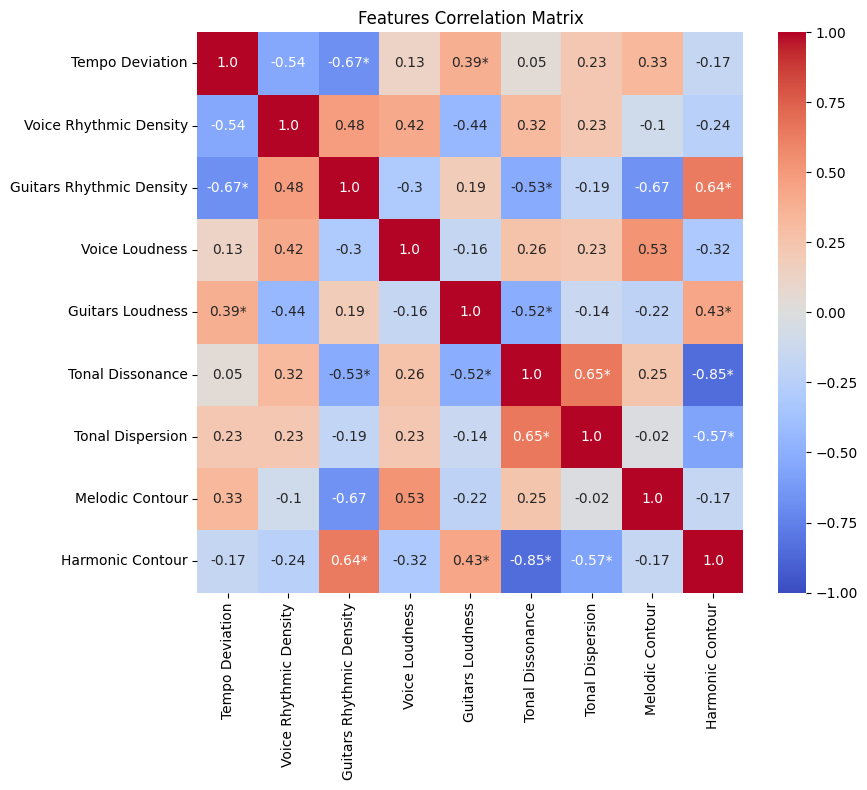

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os

# Signficance Level Parameter
significance_level = 0.05

# Apply EMD
emd_data = {}
raw_features = {
    'Tempo Deviation': bpm_diff_aligned_raw,
    'Voice Rhythmic Density': onsets['Vocals']['counts'].astype(float),
    'Guitars Rhythmic Density': onsets['Guitars']['counts'].astype(float),
    'Voice Loudness': loudness_voice_raw,
    'Guitars Loudness': loudness_guitars_raw,
    'Tonal Dissonance': df_qualities['Tonal_Dissonance'].values,
    'Tonal Dispersion': df_qualities['Tonal_Dispersion'].values,
    #'Harmonic Changes': hcf_raw_beats,
    'Melodic Contour': melodic_centroid_raw,
    'Harmonic Contour': harmonic_centroid_raw,
}

for name, values in raw_features.items():
    try:
        emd = EMD()
        imfs = emd(values)
        num_imfs = imfs.shape[0]

        if num_imfs > 1:
            emd_data[name] = np.sum(imfs[2:], axis=0)
        else:
            print(f"Warning: Not enough IMFs for {name}. Using original signal.")
            emd_data[name] = values

    except Exception as e:
        print(f"Error applying EMD to {name}: {e}")
        emd_data[name] = values


# Apply Loudness Masking
emd_data_masked = {
    'Tempo Deviation': emd_data['Tempo Deviation'],
    'Voice Rhythmic Density': apply_mask(emd_data['Voice Rhythmic Density'], voice_mask),
    'Guitars Rhythmic Density': apply_mask(emd_data['Guitars Rhythmic Density'], guitar_mask),
    'Voice Loudness': apply_mask(emd_data['Voice Loudness'], voice_mask),
    'Guitars Loudness': apply_mask(emd_data['Guitars Loudness'], guitar_mask),
    'Tonal Dissonance': emd_data['Tonal Dissonance'],
    'Tonal Dispersion': emd_data['Tonal Dispersion'],
    #'Harmonic Changes': emd_data['Harmonic Changes'],
    'Melodic Contour': apply_mask(emd_data['Melodic Contour'], voice_mask),
    'Harmonic Contour': apply_mask(emd_data['Harmonic Contour'], guitar_mask),
}

# Create dataframe and compute correlations
df_emd = pd.DataFrame(emd_data_masked)
corr_matrix = df_emd.corr(method='pearson')

# Compute p values
p_values = pd.DataFrame(np.ones(corr_matrix.shape), columns=corr_matrix.columns, index=corr_matrix.index)
for row in corr_matrix.columns:
    for col in corr_matrix.columns:
        if row != col:
            _, p = pearsonr(df_emd[row], df_emd[col])
            p_values.loc[row, col] = p

# Statistical significance matrix
annot_matrix = corr_matrix.round(2).astype(str)
for row in corr_matrix.columns:
    for col in corr_matrix.columns:
        if row != col and p_values.loc[row, col] < significance_level:
            annot_matrix.loc[row, col] += '*'

# Plot
os.makedirs("saved_plots", exist_ok=True)
plt.figure(figsize=(9, 8))
sns.heatmap(corr_matrix, annot=annot_matrix, fmt='', cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Features Correlation Matrix")
plt.tight_layout()
plt.savefig("saved_plots/plot_6.pdf", bbox_inches="tight")
plt.show()

## 10) Plots

In [11]:
def minmax_normalize(x):
    x = np.asarray(x, dtype=float)
    finite = np.isfinite(x)
    if not np.any(finite):
        return np.zeros_like(x)
    lo, hi = np.nanmin(x[finite]), np.nanmax(x[finite])
    if hi - lo < 1e-9:
        y = np.zeros_like(x)
    else:
        y = (x - lo) / (hi - lo)
    y[~finite] = np.nan # Keep NaNs as NaN after normalization
    return y

def format_axes(ax, x_axis, df_sections, df_phrases, title=None, mode="time"):
    def sec_to_minsec(t):
        m = int(t // 60)
        s = int(round(t % 60))
        return f"{m}:{s:02d}"

    x_axis = np.asarray(x_axis)
    if x_axis.size == 0:
        return

    n_ticks = 10
    # Ensure tick positions are within the range of x_axis
    tick_positions = np.linspace(x_axis[0] if x_axis.size > 0 else 0, x_axis[-1] if x_axis.size > 0 else 1, n_ticks)

    if mode == "beats":
        ax.set_xticks(tick_positions)
        # Find corresponding beat numbers for time tick positions
        # This assumes beat_times is a monotonically increasing array of times for each beat
        beat_indices = np.searchsorted(beat_times, tick_positions)
        # Ensure indices are within bounds of beat_times if needed, or use beat numbers directly if x_axis is beat index
        beat_labels = beat_indices + 1 # Beat numbers are typically 1-indexed
        ax.set_xticklabels([f"{b}" for b in beat_labels], fontsize=9)
        ax.set_xlabel("Beat")

        ax_top = ax.secondary_xaxis('top')
        ax_top.set_xticks(tick_positions)
        ax_top.set_xticklabels([sec_to_minsec(t) for t in tick_positions], fontsize=9)
        ax_top.set_xlabel("Time (mm:ss)")
    else: # mode == "time"
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([sec_to_minsec(t) for t in tick_positions], fontsize=9)
        ax.set_xlabel("Time (mm:ss)")

        ax_top = ax.secondary_xaxis('top')
        ax_top.set_xticks(tick_positions)
         # Find corresponding beat numbers for time tick positions
        beat_indices = np.searchsorted(beat_times, tick_positions)
        beat_labels = beat_indices + 1 # Beat numbers are typically 1-indexed
        ax_top.set_xticklabels([f"{b}" for b in beat_labels], fontsize=9)
        ax_top.set_xlabel("Beat")


    if df_sections is not None and all(c in df_sections.columns for c in ["Initial_Time", "Label"]):
        for time, label in zip(df_sections["Initial_Time"], df_sections["Label"]):
            ax.axvline(x=time, color="black", lw=1.2, alpha=0.9)
            ax.text(time, -0.18, label, rotation=90, ha="center", va="top",
                    fontsize=8, color="black", transform=ax.get_xaxis_transform(), clip_on=False)

    if df_phrases is not None and all(c in df_phrases.columns for c in ["Initial_Time", "Label"]):
        for t, lab in zip(df_phrases["Initial_Time"], df_phrases["Label"]):
            ax.axvline(x=t, color="lightgrey", lw=1.0, alpha=0.7)
            ax.text(t, 1.15, lab, rotation=90, ha="center", va="bottom", # Adjusted va and y position
                    fontsize=8, color="grey", transform=ax.get_xaxis_transform(), clip_on=False)


    if title:
        ax.set_title(title, pad=70) # Increased pad for title

    ax.margins(x=0.05)
    ax.grid(False) # Ensure grid is off by default

def plot(variables, norm=False, smoothing=0, x_axis=None, df_sections=None, df_phrases=None,
         title=None, mode="time", plot_index=None, peaks=None, y_label=None):
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.ndimage import gaussian_filter1d

    def get_variable_array(name):
        try:
            return np.asarray(eval(name), dtype=float)
        except Exception as e:
            print(f"Error accessing variable '{name}': {e}")
            return None

    if isinstance(variables, list):
        fig, ax = plt.subplots(figsize=(18, 6), constrained_layout=True)

        global_min, global_max = np.inf, -np.inf

        for var in variables:
            if isinstance(var, tuple):
                if len(var) == 4:
                    name, nrm, smooth, label = var
                else:
                    name, nrm, smooth = var
                    label = name
            else:
                name, nrm, smooth, label = var, norm, smoothing, var

            y = get_variable_array(name)

            if y is None or len(y) == 0:
                print(f"Variable '{name}' not found or empty.")
                continue

            y_plot = np.copy(y)

            if nrm:
                y_plot = minmax_normalize(y_plot)
            if smooth > 0:
                finite_mask = np.isfinite(y_plot)
                if np.any(finite_mask):
                    y_plot[finite_mask] = gaussian_filter1d(y_plot[finite_mask], sigma=smooth)

            if x_axis is not None:
                x_axis = np.asarray(x_axis)
                min_len = min(len(x_axis), len(y_plot))
                x_vals = x_axis[:min_len]
                y_plot = y_plot[:min_len]
            else:
                x_vals = np.arange(len(y_plot))

            y_masked = np.ma.masked_invalid(y_plot)
            ax.plot(x_vals, y_masked, label=label)

            finite_y_plot = y_plot[np.isfinite(y_plot)]
            if finite_y_plot.size > 0:
                if not nrm:
                    global_min = min(global_min, np.min(finite_y_plot))
                    global_max = max(global_max, np.max(finite_y_plot))

            if peaks and name in peaks:
                peak_indices = peaks[name]
                valid_peak_indices = peak_indices[peak_indices < len(x_vals)]
                peak_times = x_vals[valid_peak_indices]
                peak_values = y_plot[valid_peak_indices]
                ax.scatter(peak_times, peak_values, color='red', label=f"{label} Peaks")

        if not norm and np.isfinite(global_min) and np.isfinite(global_max):
            y_range = global_max - global_min
            if y_range < 1e-9:
                ax.set_ylim(global_min - 0.1, global_max + 0.1)
            else:
                ax.set_ylim(global_min - y_range * 0.05, global_max + y_range * 0.05)
        elif norm:
            ax.set_ylim(-0.05, 1.05)

        if x_axis is not None and isinstance(x_axis, (list, np.ndarray)) and len(x_axis) > 0:
            format_axes(ax, x_axis, df_sections, df_phrases, title=title, mode=mode)

        if y_label is not None:
            ax.set_ylabel(y_label)

        ax.legend()

        if plot_index is not None:
            os.makedirs("./saved_plots", exist_ok=True)
            plot_path = os.path.join("./saved_plots", f"plot_{plot_index}.pdf")
            plt.savefig(plot_path, bbox_inches="tight")
            print(f"Saved plot to {plot_path}")

        plt.show()

Saved plot to ./saved_plots/plot_7.pdf


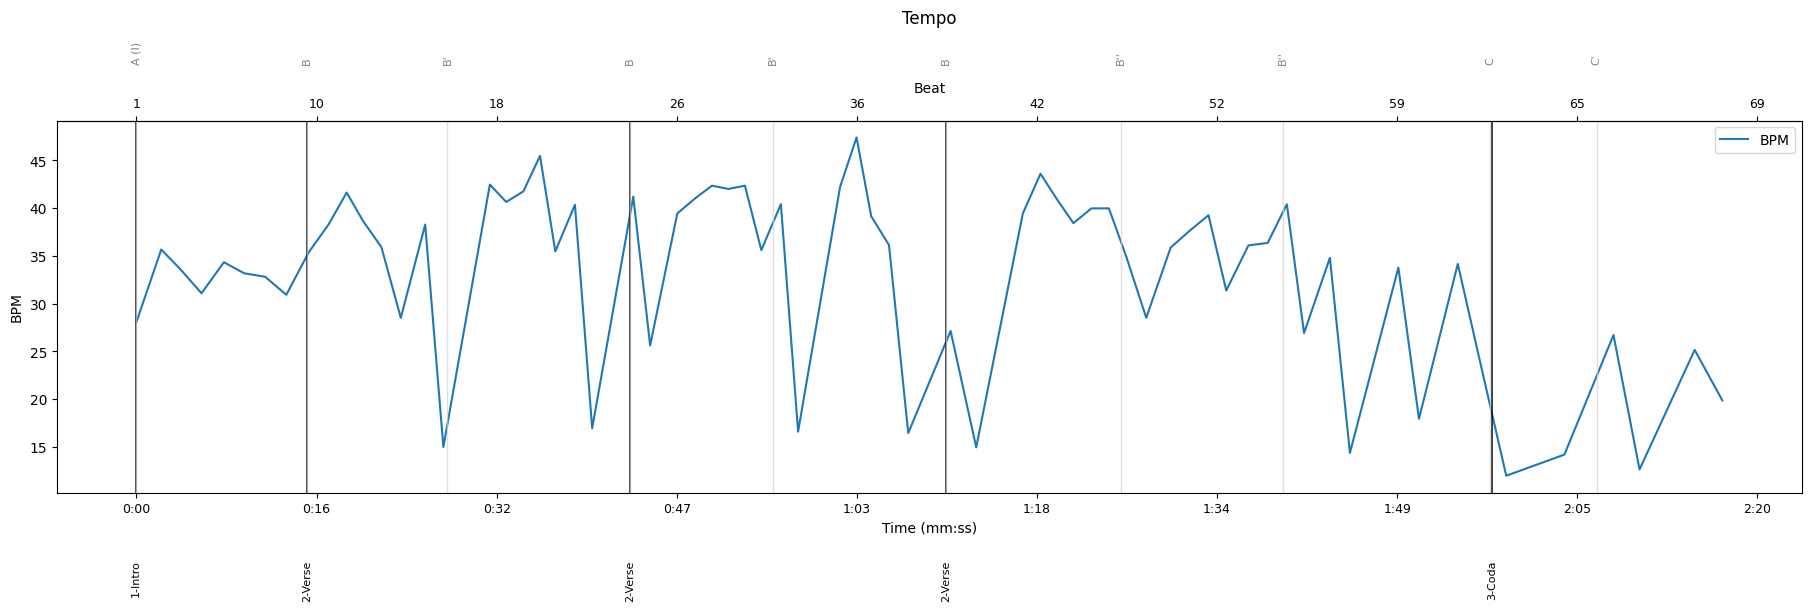

Saved plot to ./saved_plots/plot_8.pdf


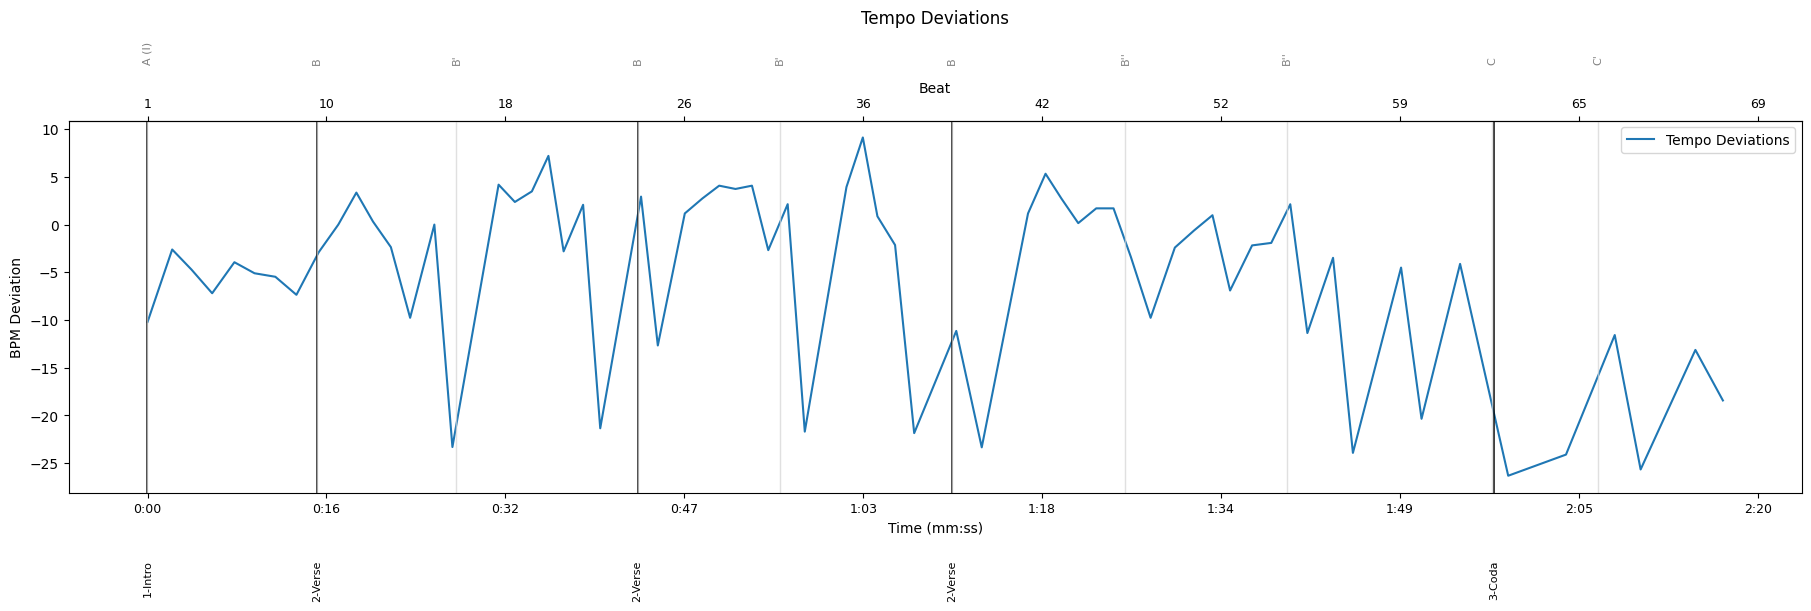

Saved plot to ./saved_plots/plot_9.pdf


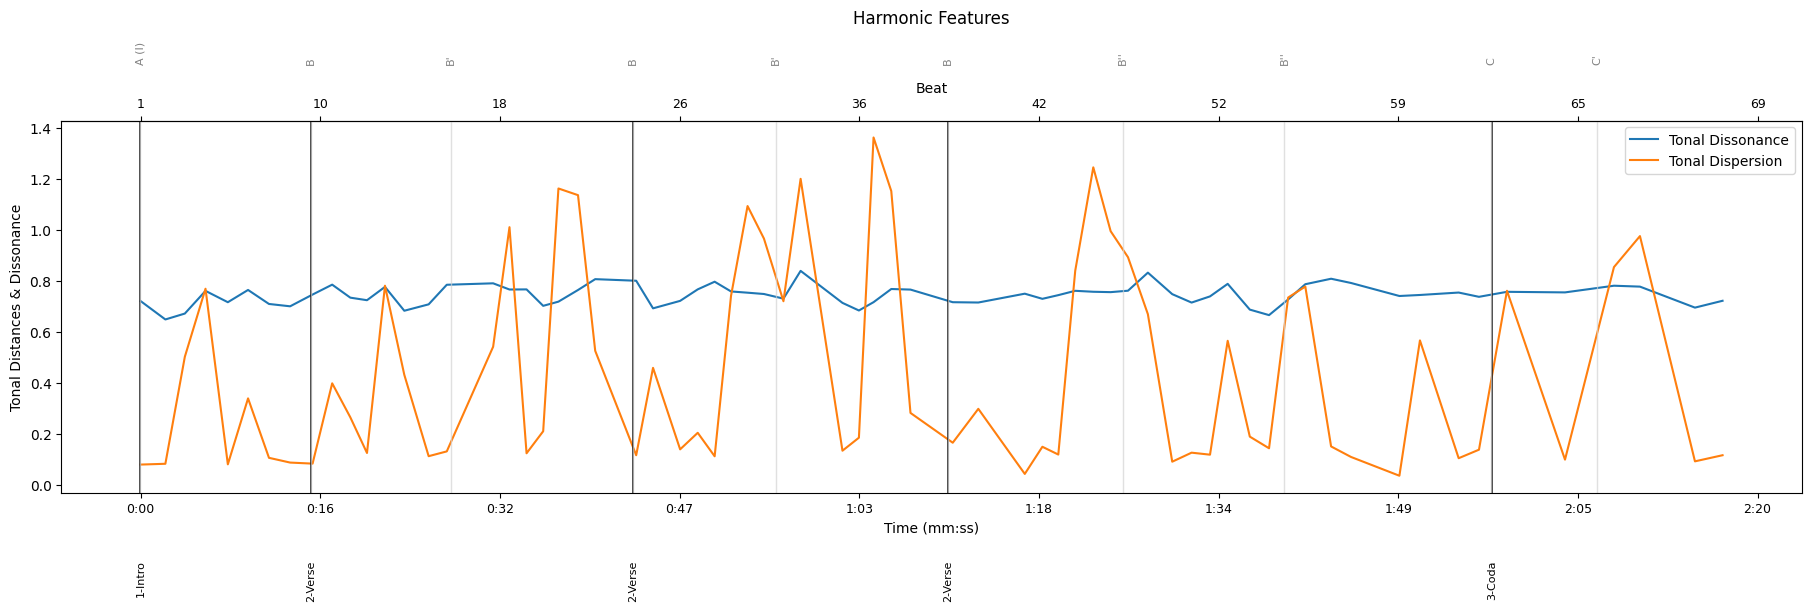

Saved plot to ./saved_plots/plot_10.pdf


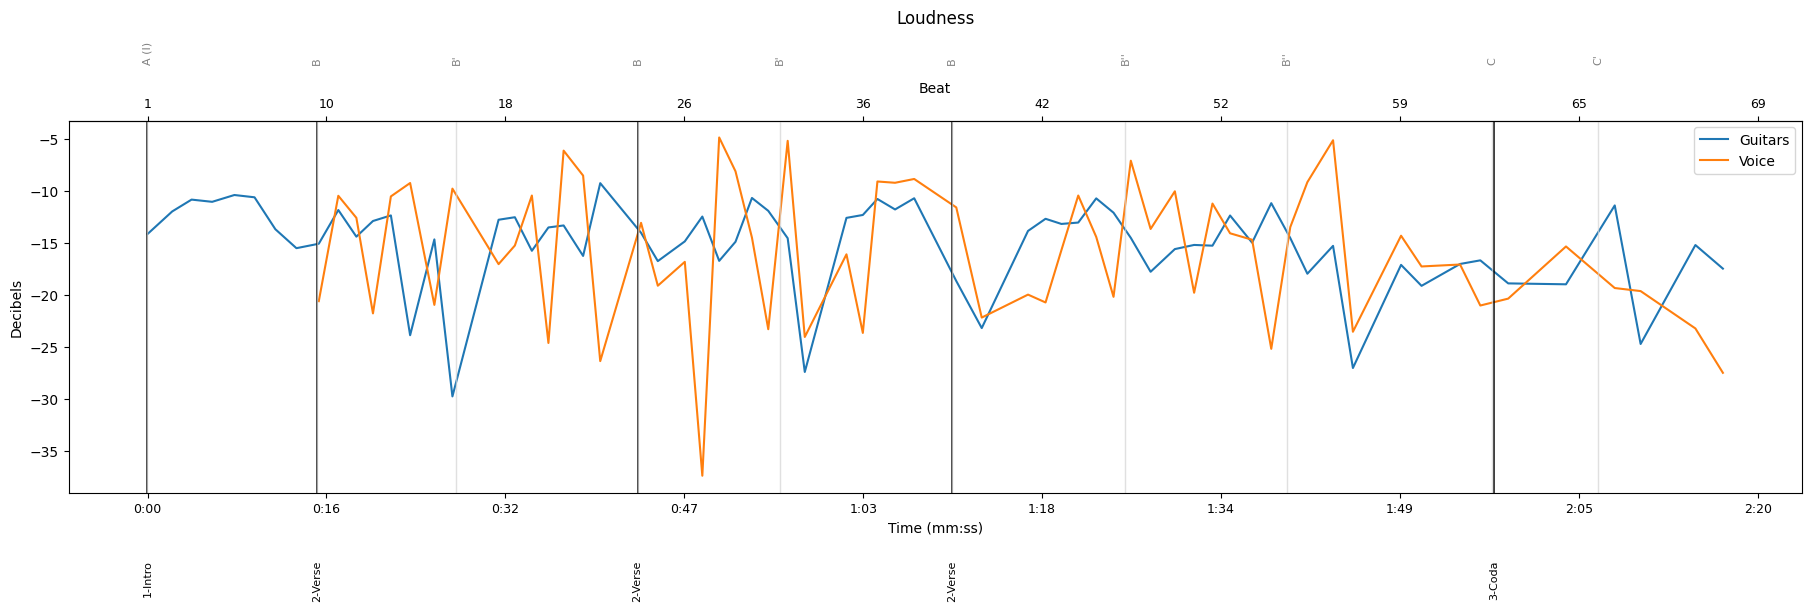

Saved plot to ./saved_plots/plot_11.pdf


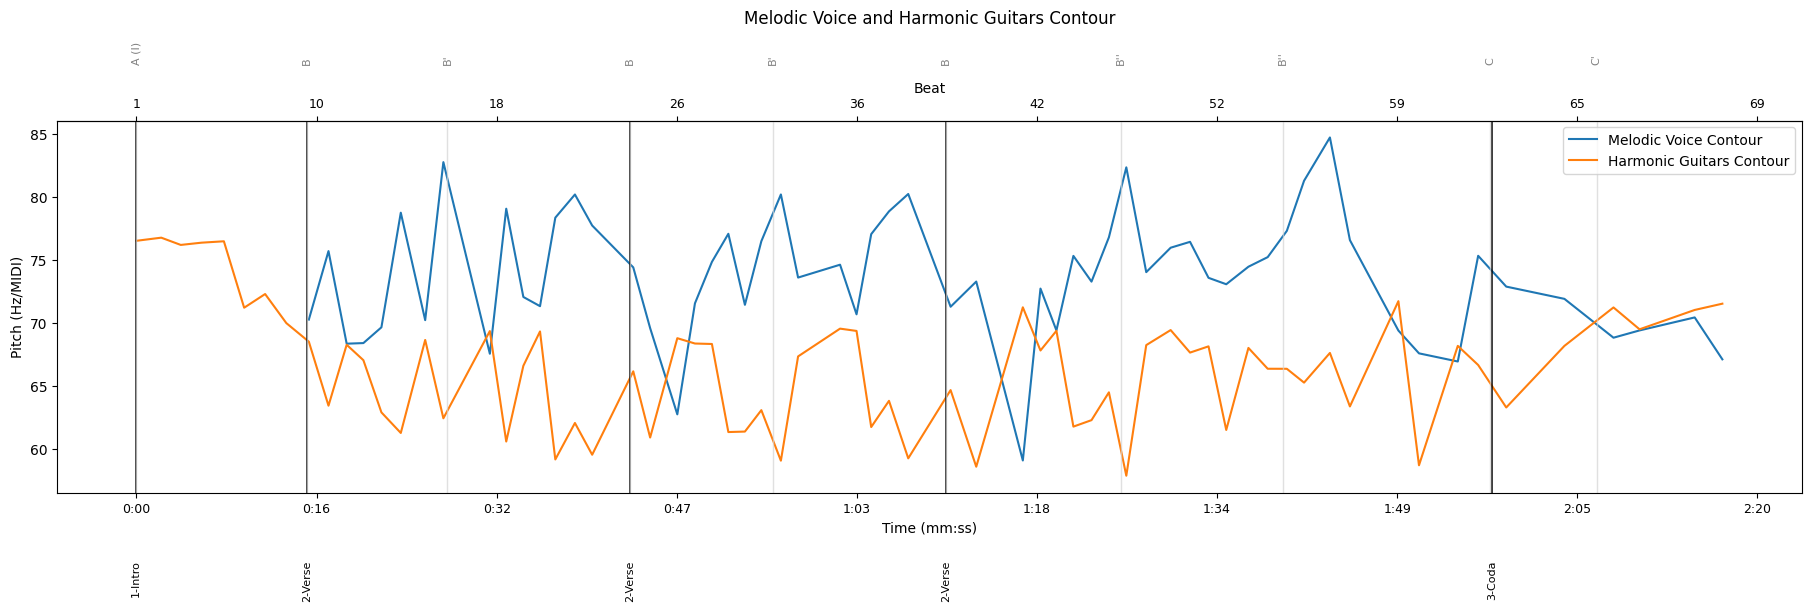

Saved plot to ./saved_plots/plot_12.pdf


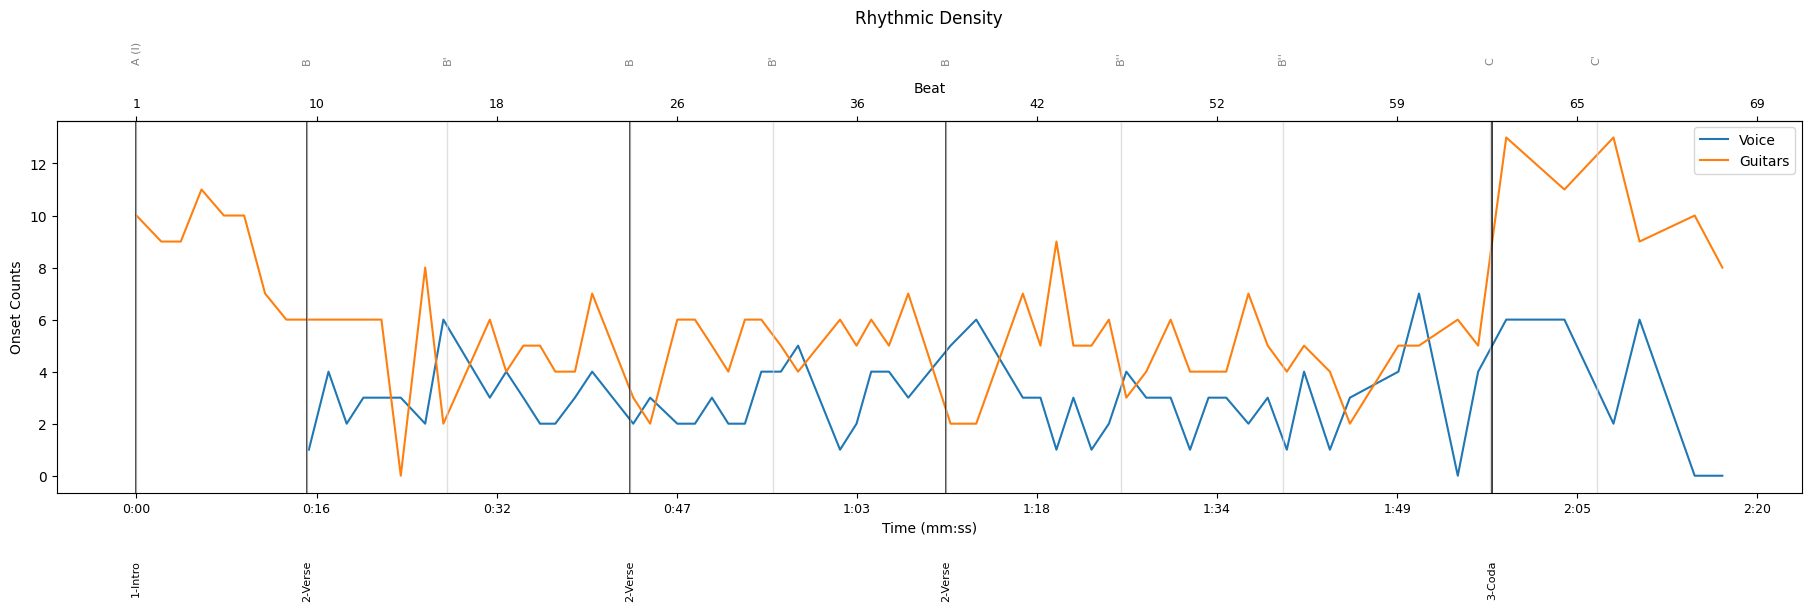

Saved plot to ./saved_plots/plot_13.pdf


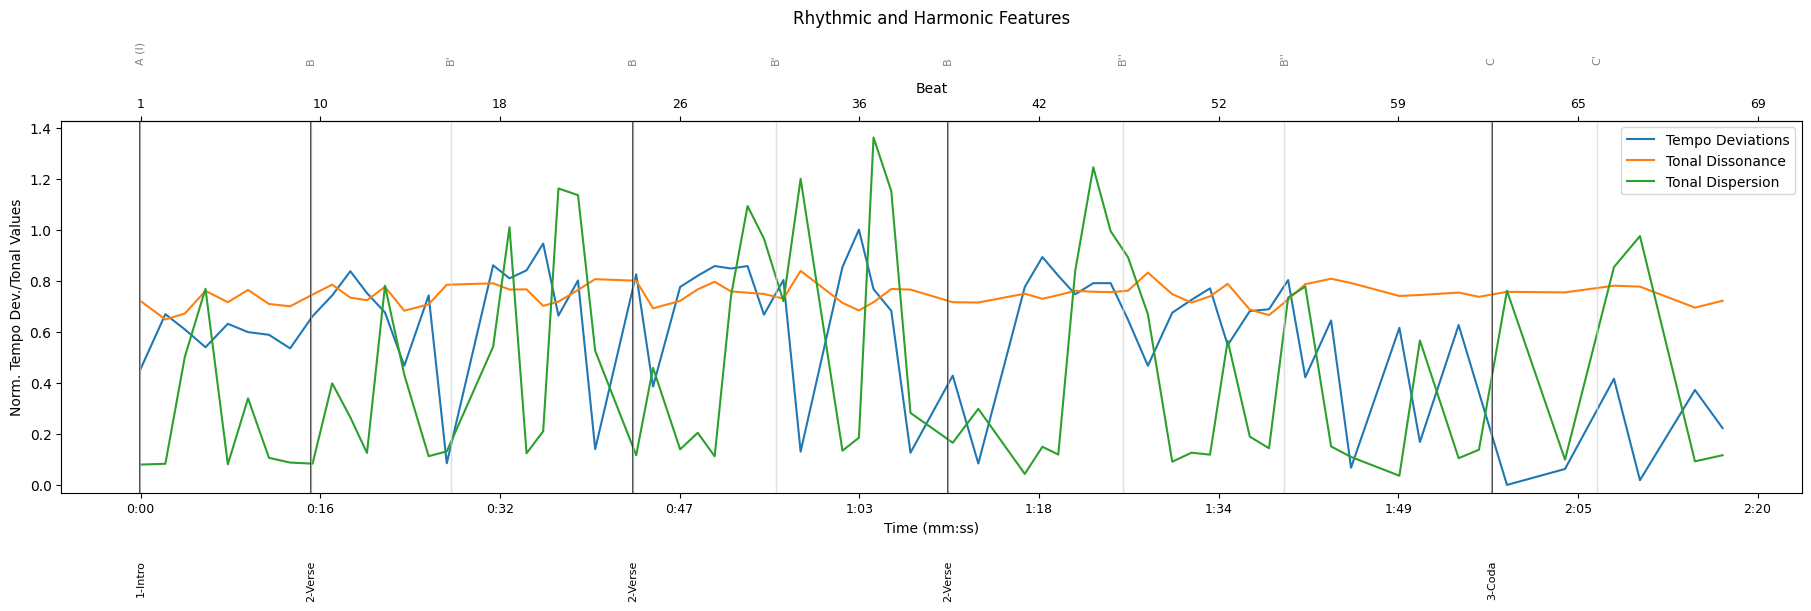

Saved plot to ./saved_plots/plot_14.pdf


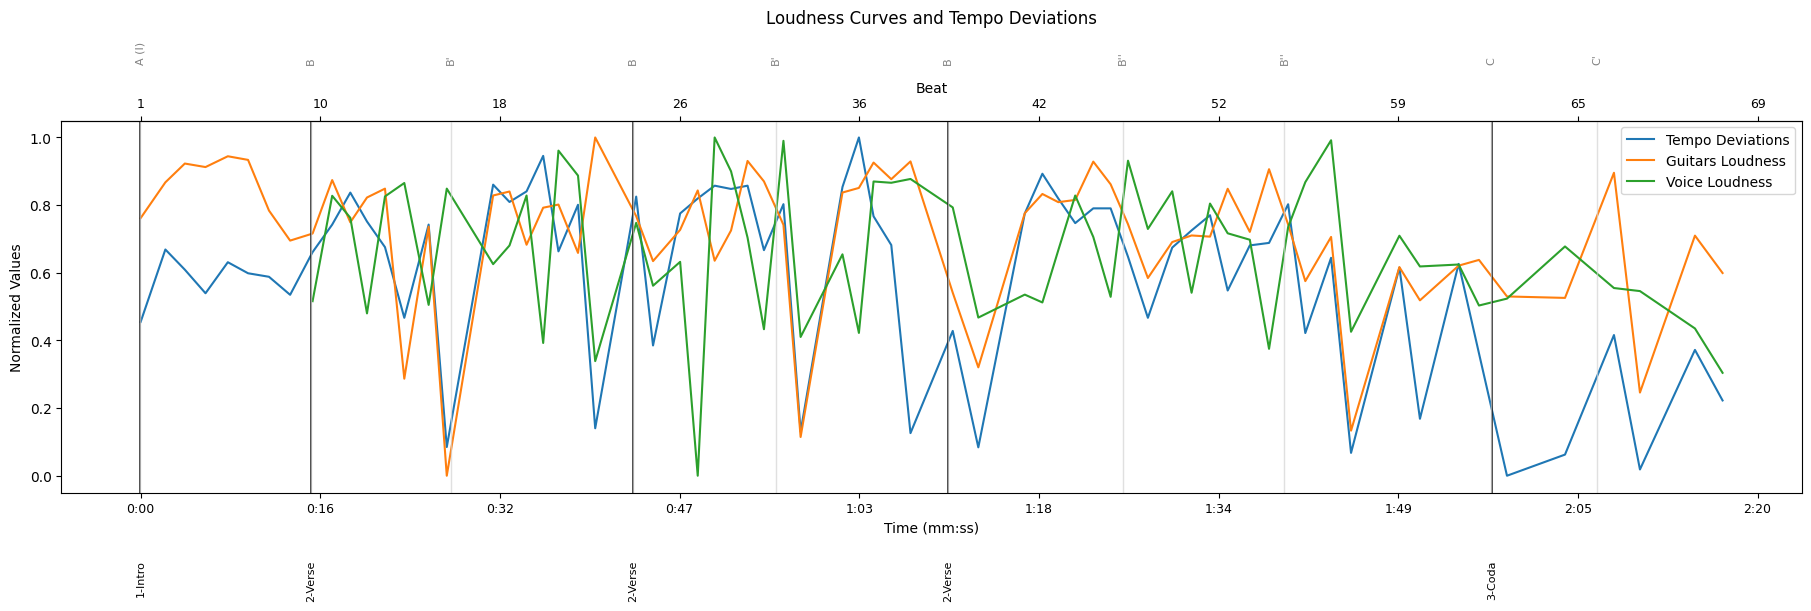

Saved plot to ./saved_plots/plot_15.pdf


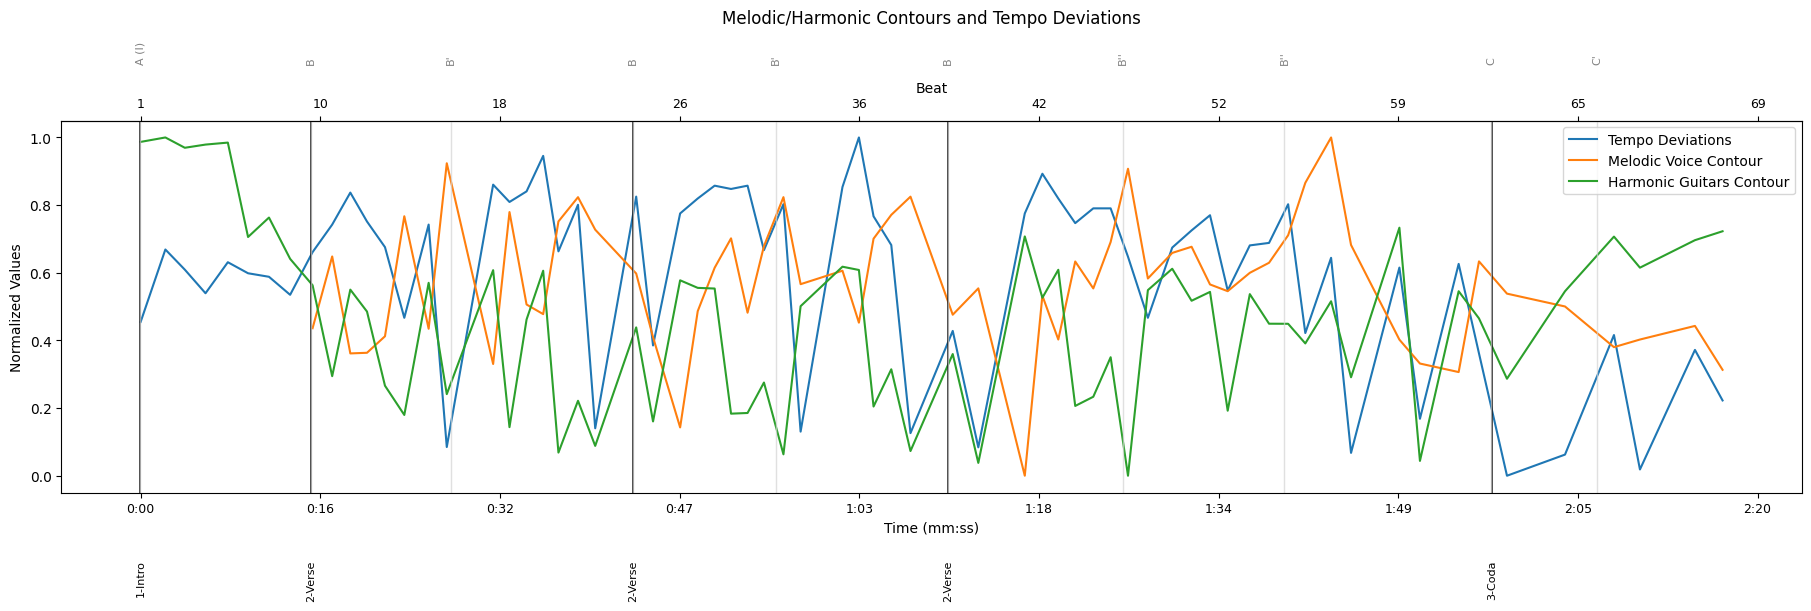

Saved plot to ./saved_plots/plot_16.pdf


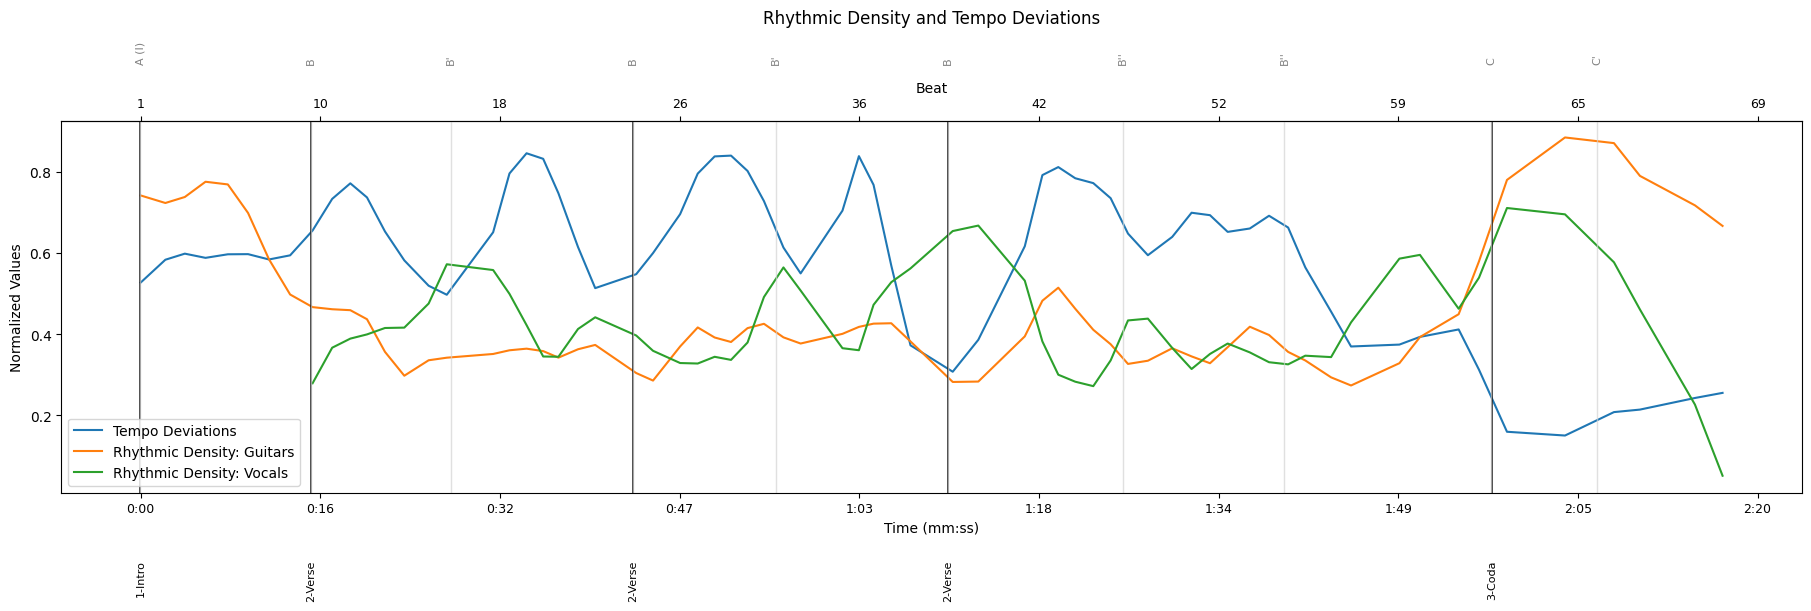

Saved plot to ./saved_plots/plot_17.pdf


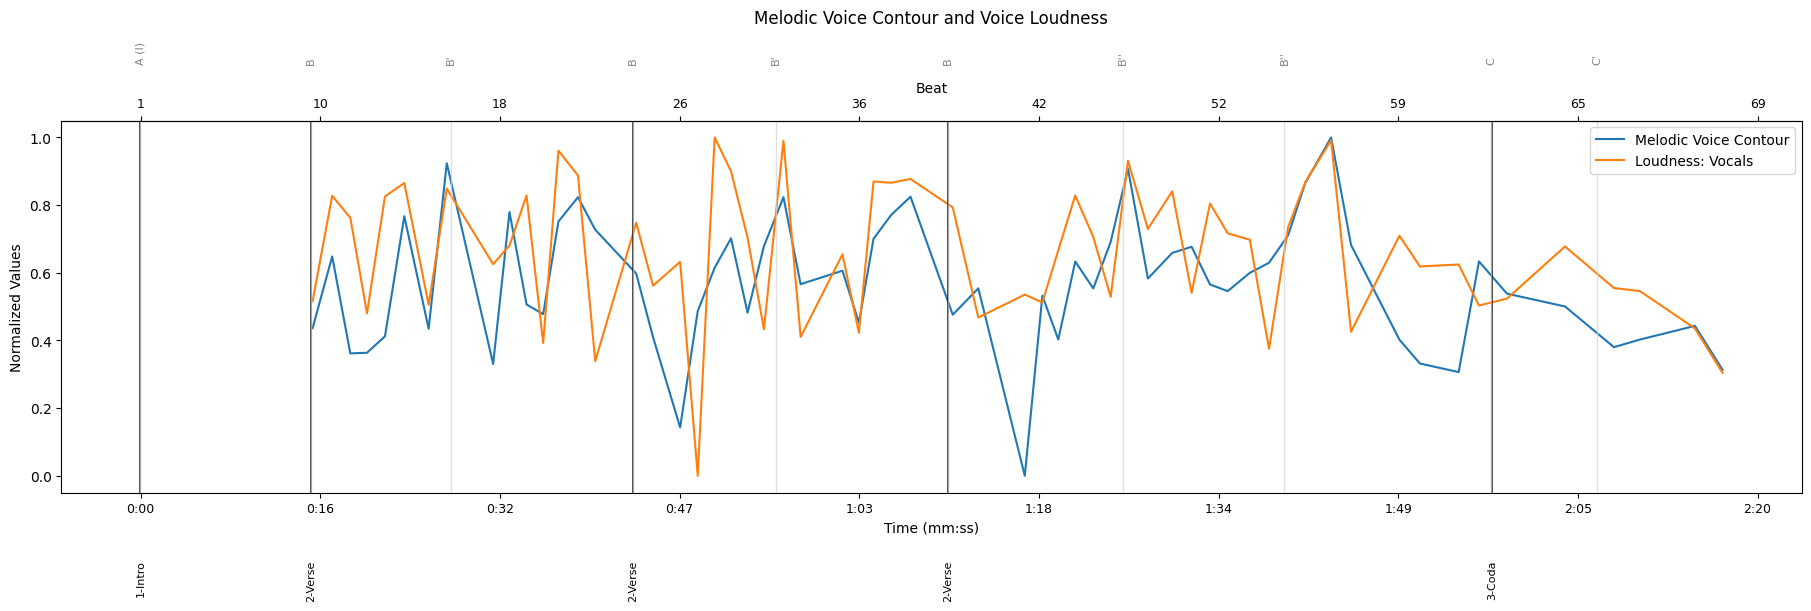

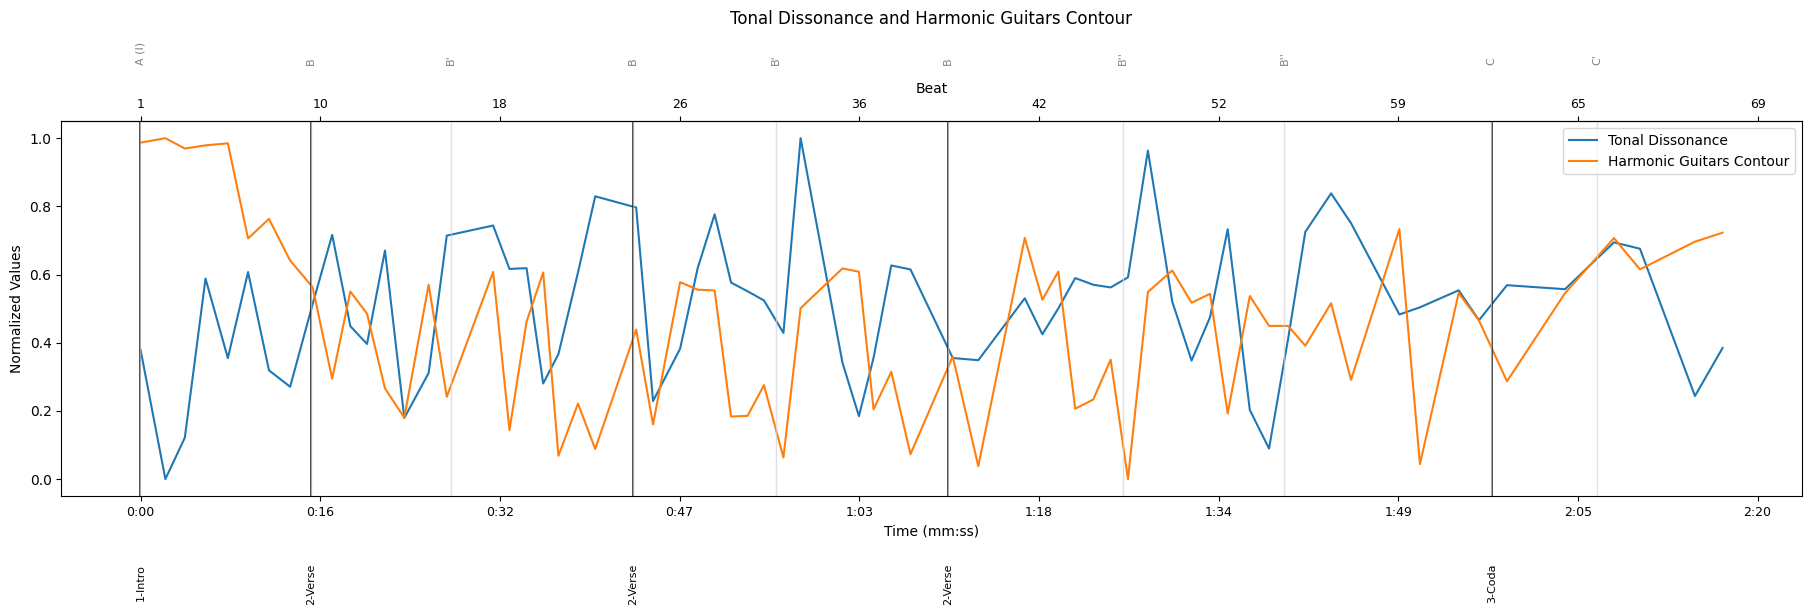

In [12]:
plot([
    ("bpm_series['bpms_raw']", False, 0, "BPM")],
     title="Tempo", y_label="BPM", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=7)

plot([
    ("bpm_diff_aligned_raw", False, 0, "Tempo Deviations")],
     title="Tempo Deviations", y_label="BPM Deviation", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=8)

plot([
    ("df_qualities['Tonal_Dissonance']", False, 0, "Tonal Dissonance"),
    ("df_qualities['Tonal_Dispersion']", False, 0, "Tonal Dispersion")
], title="Harmonic Features", y_label="Tonal Distances & Dissonance", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=9)

plot([
    ("apply_mask(loudness_guitars_raw, guitar_mask)", False, 0, "Guitars"),
    ("apply_mask(loudness_voice_raw, voice_mask)", False, 0, "Voice")
], title="Loudness", y_label="Decibels", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=10)

plot([
    ("apply_mask(melodic_centroid_raw, voice_mask)", False, 0, "Melodic Voice Contour"),
    ("apply_mask(harmonic_centroid_raw, guitar_mask)", False, 0, "Harmonic Guitars Contour")
], title="Melodic Voice and Harmonic Guitars Contour", y_label="Pitch (Hz/MIDI)", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=11)

plot([
    ("apply_mask(onsets['Vocals']['counts'], voice_mask)", False, 0, "Voice"),
    ("apply_mask(onsets['Guitars']['counts'], guitar_mask)", False, 0, "Guitars")
], title="Rhythmic Density", y_label="Onset Counts", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=12)

plot([
    ("bpm_diff_aligned_raw", True, 0, "Tempo Deviations"),
    ("df_qualities['Tonal_Dissonance']", False, 0, "Tonal Dissonance"),
    ("df_qualities['Tonal_Dispersion']", False, 0, "Tonal Dispersion")
], title="Rhythmic and Harmonic Features", y_label="Norm. Tempo Dev./Tonal Values", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=13)

plot([
    ("bpm_diff_aligned_raw", True, 0, "Tempo Deviations"),
    ("apply_mask(loudness_guitars_raw, guitar_mask)", True, 0, "Guitars Loudness"),
    ("apply_mask(loudness_voice_raw, voice_mask)", True, 0, "Voice Loudness")
], title="Loudness Curves and Tempo Deviations", y_label="Normalized Values", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=14)

plot([
    ("bpm_diff_aligned_raw", True, 0, "Tempo Deviations"),
    ("apply_mask(melodic_centroid_raw, voice_mask)", True, 0, "Melodic Voice Contour"),
    ("apply_mask(harmonic_centroid_raw, guitar_mask)", True, 0, "Harmonic Guitars Contour")
], title="Melodic/Harmonic Contours and Tempo Deviations", y_label="Normalized Values", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=15)

plot([
    ("bpm_diff_aligned_raw", True, 1, "Tempo Deviations"),
    ("apply_mask(onsets['Guitars']['counts'], guitar_mask)", True, 1, "Rhythmic Density: Guitars"),
    ("apply_mask(onsets['Vocals']['counts'], voice_mask)", True, 1, "Rhythmic Density: Vocals")
], title="Rhythmic Density and Tempo Deviations", y_label="Normalized Values", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=16)

plot([
    ("apply_mask(melodic_centroid_raw, voice_mask)", True, 0, "Melodic Voice Contour"),
    ("apply_mask(loudness_voice_raw, voice_mask)", True, 0, "Loudness: Vocals")
], title="Melodic Voice Contour and Voice Loudness", y_label="Normalized Values", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=17)

plot([
    ("df_qualities['Tonal_Dissonance']", True, 0, "Tonal Dissonance"),
    ("apply_mask(harmonic_centroid_raw, guitar_mask)", True, 0, "Harmonic Guitars Contour")
], title="Tonal Dissonance and Harmonic Guitars Contour", y_label="Normalized Values", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=None)

## Residual Analysis (Outliers Detection)

Skipping (Tempo Deviation, Voice Rhythmic Density): correlation -0.54 < 0.6 or NaN.
Saved plot to saved_plots/plot_18.pdf


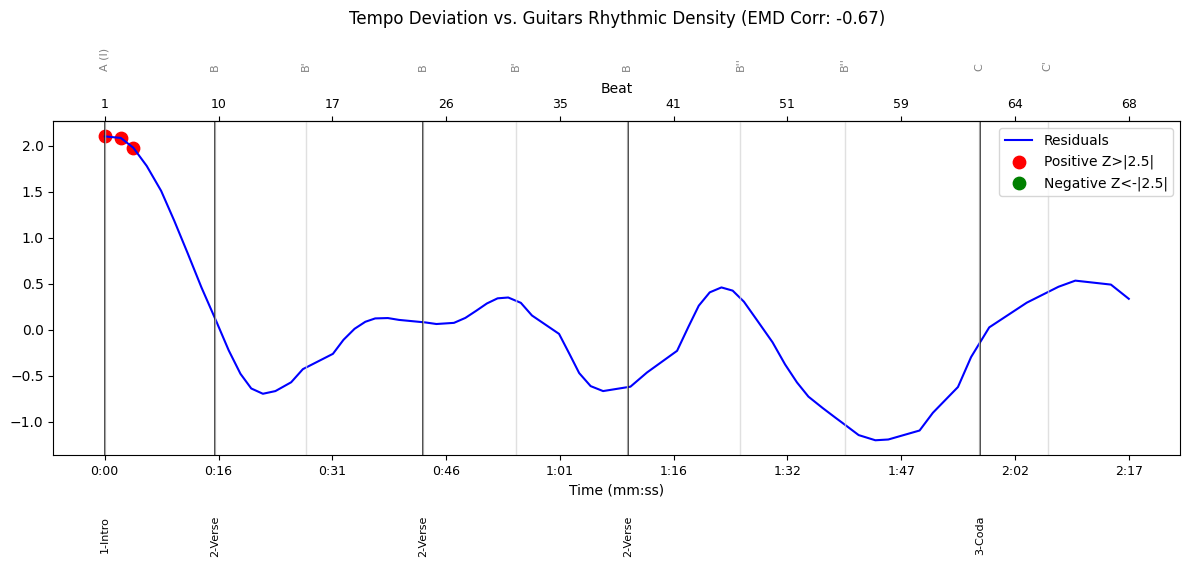

Skipping (Tempo Deviation, Voice Loudness): correlation 0.13 < 0.6 or NaN.
Skipping (Tempo Deviation, Guitars Loudness): correlation 0.39 < 0.6 or NaN.
Skipping (Tempo Deviation, Tonal Dissonance): correlation 0.05 < 0.6 or NaN.
Skipping (Tempo Deviation, Tonal Dispersion): correlation 0.23 < 0.6 or NaN.
Skipping (Tempo Deviation, Melodic Contour): correlation 0.33 < 0.6 or NaN.
Skipping (Tempo Deviation, Harmonic Contour): correlation -0.17 < 0.6 or NaN.
Skipping (Voice Rhythmic Density, Guitars Rhythmic Density): correlation 0.48 < 0.6 or NaN.
Skipping (Voice Rhythmic Density, Voice Loudness): correlation 0.42 < 0.6 or NaN.
Skipping (Voice Rhythmic Density, Guitars Loudness): correlation -0.44 < 0.6 or NaN.
Skipping (Voice Rhythmic Density, Tonal Dissonance): correlation 0.32 < 0.6 or NaN.
Skipping (Voice Rhythmic Density, Tonal Dispersion): correlation 0.23 < 0.6 or NaN.
Skipping (Voice Rhythmic Density, Melodic Contour): correlation -0.10 < 0.6 or NaN.
Skipping (Voice Rhythmic Dens

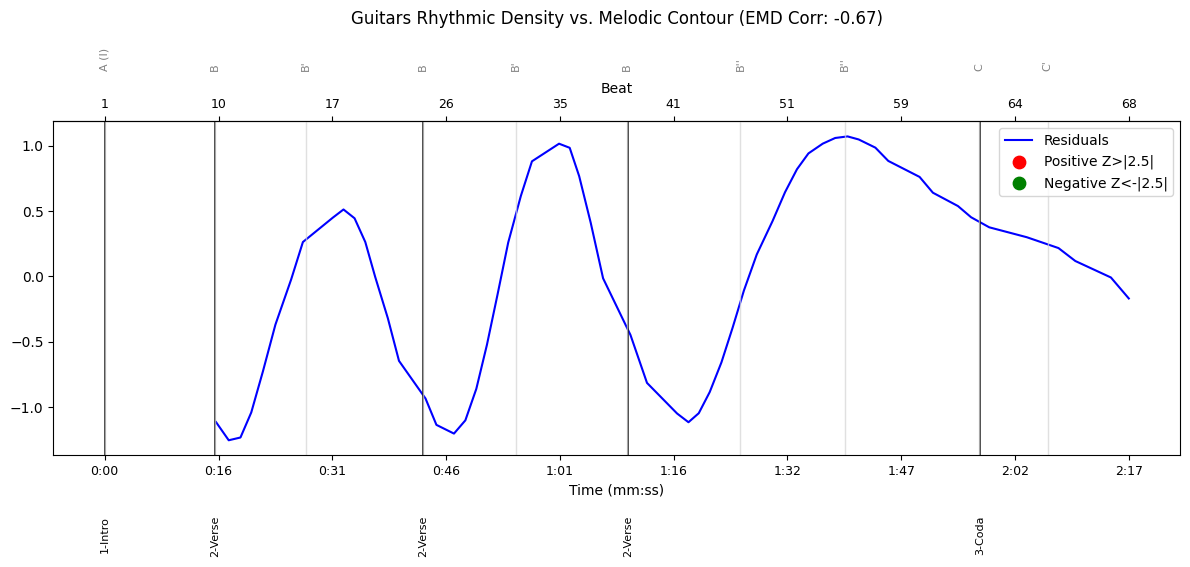

Saved plot to saved_plots/plot_20.pdf


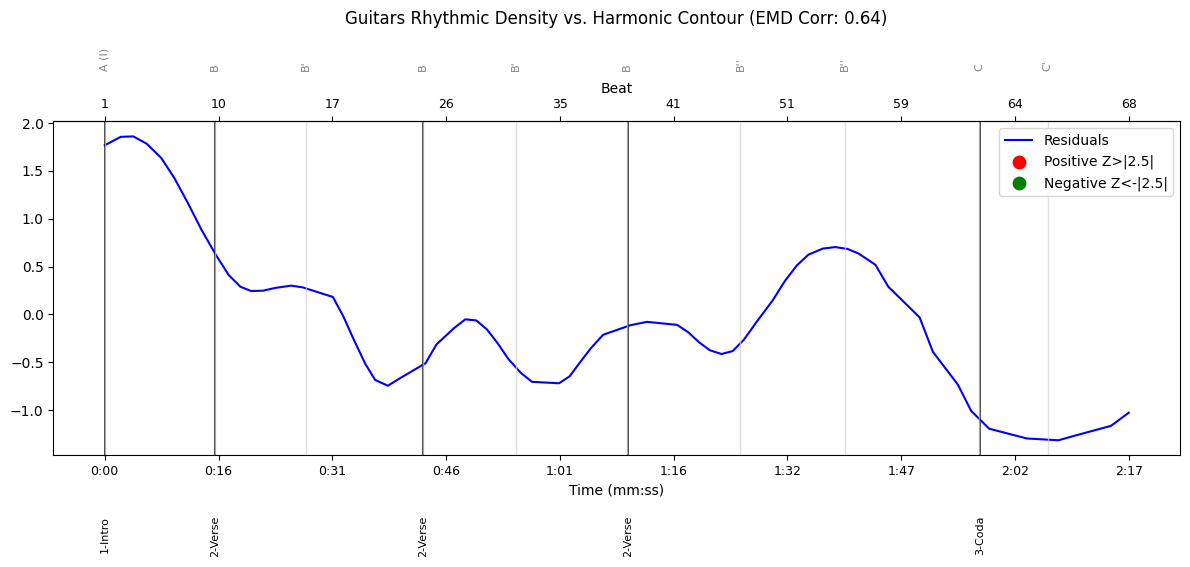

Skipping (Voice Loudness, Guitars Loudness): correlation -0.16 < 0.6 or NaN.
Skipping (Voice Loudness, Tonal Dissonance): correlation 0.26 < 0.6 or NaN.
Skipping (Voice Loudness, Tonal Dispersion): correlation 0.23 < 0.6 or NaN.
Skipping (Voice Loudness, Melodic Contour): correlation 0.53 < 0.6 or NaN.
Skipping (Voice Loudness, Harmonic Contour): correlation -0.32 < 0.6 or NaN.
Skipping (Guitars Loudness, Tonal Dissonance): correlation -0.52 < 0.6 or NaN.
Skipping (Guitars Loudness, Tonal Dispersion): correlation -0.14 < 0.6 or NaN.
Skipping (Guitars Loudness, Melodic Contour): correlation -0.22 < 0.6 or NaN.
Skipping (Guitars Loudness, Harmonic Contour): correlation 0.43 < 0.6 or NaN.
Saved plot to saved_plots/plot_21.pdf


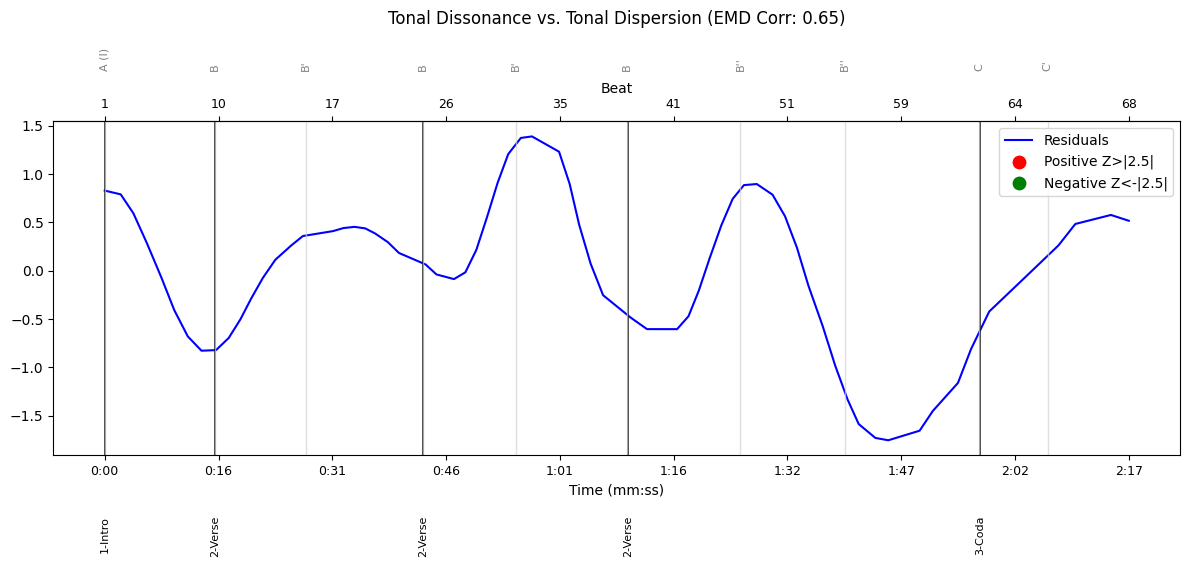

Skipping (Tonal Dissonance, Melodic Contour): correlation 0.25 < 0.6 or NaN.
Saved plot to saved_plots/plot_22.pdf


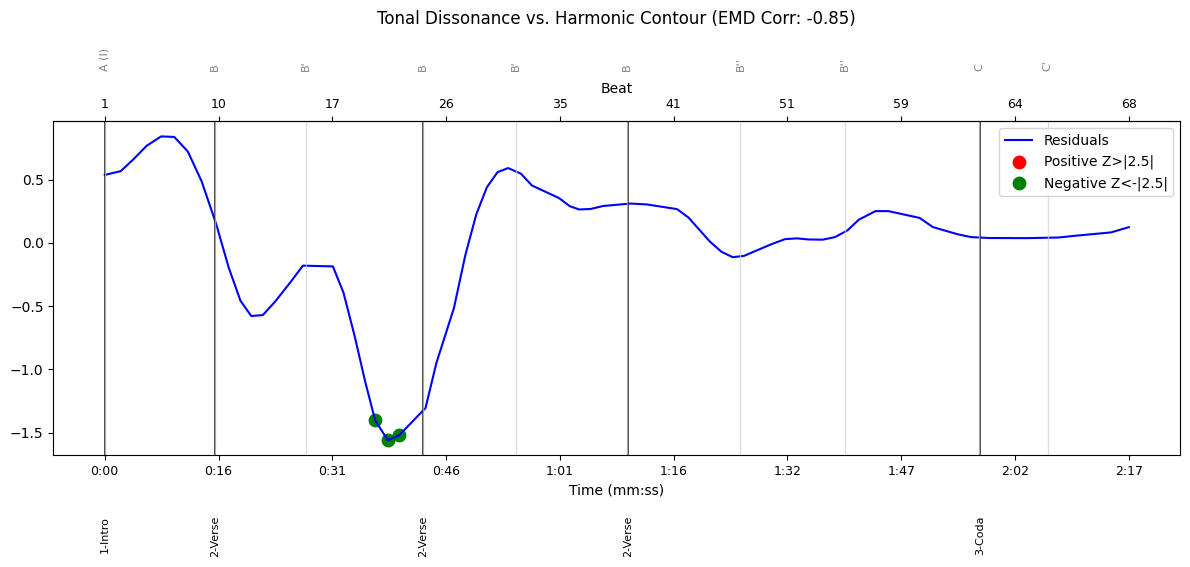

Skipping (Tonal Dispersion, Melodic Contour): correlation -0.02 < 0.6 or NaN.
Skipping (Tonal Dispersion, Harmonic Contour): correlation -0.57 < 0.6 or NaN.
Skipping (Melodic Contour, Harmonic Contour): correlation -0.17 < 0.6 or NaN.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import itertools
import os

# Parameters
normalize_curves = True  # Set to False if you want raw values
z_threshold = 2.5        # Z-score threshold for outliers

# Create output directory
os.makedirs("saved_plots", exist_ok=True)
plot_counter = 18  # Starting index

# Data dictionary
data_for_distance = {
    'Tempo Deviation': emd_data_masked['Tempo Deviation'],
    'Voice Rhythmic Density': emd_data_masked['Voice Rhythmic Density'],
    'Guitars Rhythmic Density': emd_data_masked['Guitars Rhythmic Density'],
    'Voice Loudness': emd_data_masked['Voice Loudness'],
    'Guitars Loudness': emd_data_masked['Guitars Loudness'],
    'Tonal Dissonance': emd_data_masked['Tonal Dissonance'],
    'Tonal Dispersion': emd_data_masked['Tonal Dispersion'],
    'Melodic Contour': emd_data_masked['Melodic Contour'],
    'Harmonic Contour': emd_data_masked['Harmonic Contour'],
}

for var_a, var_b in itertools.combinations(data_for_distance.keys(), 2):
    a, b = data_for_distance[var_a], data_for_distance[var_b]
    if len(a) == 0 or len(b) == 0:
        print(f"Skipping ({var_a}, {var_b}): empty series.")
        continue

    # Apply masks
    if "Voice" in var_a:
        a = apply_mask(a, voice_mask)
    elif "Guitars" in var_a:
        a = apply_mask(a, guitar_mask)

    if "Voice" in var_b:
        b = apply_mask(b, voice_mask)
    elif "Guitars" in var_b:
        b = apply_mask(b, guitar_mask)

    # Synchronize lengths
    min_len = min(len(a), len(b))
    a_sync, b_sync = np.asarray(a[:min_len]), np.asarray(b[:min_len])
    time_axis = beat_times[:min_len]

    # Preserve NaNs in residuals
    residuals = np.full_like(b_sync, np.nan, dtype=float)
    valid_mask = np.isfinite(a_sync) & np.isfinite(b_sync)
    if np.sum(valid_mask) < 2:
        print(f"Skipping ({var_a}, {var_b}): insufficient valid data.")
        continue

    # Correlation check
    corr = corr_matrix.loc[var_a, var_b] if var_a in corr_matrix.columns and var_b in corr_matrix.index else 0
    if not np.isfinite(corr) or abs(corr) < 0.6:
        print(f"Skipping ({var_a}, {var_b}): correlation {corr:.2f} < 0.6 or NaN.")
        continue

    # Optional normalization
    if normalize_curves:
        a_valid = (a_sync[valid_mask] - np.mean(a_sync[valid_mask])) / np.std(a_sync[valid_mask])
        b_valid = (b_sync[valid_mask] - np.mean(b_sync[valid_mask])) / np.std(b_sync[valid_mask])
    else:
        a_valid = a_sync[valid_mask]
        b_valid = b_sync[valid_mask]

    # Linear regression
    model = LinearRegression()
    model.fit(a_valid.reshape(-1, 1), b_valid)
    predicted = model.predict(a_valid.reshape(-1, 1))
    residuals[valid_mask] = b_valid - predicted

    # Z-score outlier detection
    finite_vals = residuals[np.isfinite(residuals)]
    z_scores = (finite_vals - np.mean(finite_vals)) / np.std(finite_vals)
    pos_idx = np.where(z_scores > z_threshold)[0]
    neg_idx = np.where(z_scores < -z_threshold)[0]
    pos_times = time_axis[valid_mask][pos_idx]
    neg_times = time_axis[valid_mask][neg_idx]

    # Plot without interpolation across NaNs
    plt.figure(figsize=(12, 6))
    start = None
    for i in range(len(residuals)):
        if np.isfinite(residuals[i]):
            if start is None:
                start = i
        else:
            if start is not None:
                plt.plot(time_axis[start:i], residuals[start:i], color='blue', label="Residuals" if start == 0 else "")
                start = None
    if start is not None:
        plt.plot(time_axis[start:], residuals[start:], color='blue', label="Residuals")

    # Highlight positive and negative Z-score outliers
    plt.scatter(pos_times, residuals[valid_mask][pos_idx], color='red', marker='o', s=80, label=f'Positive Z>|{z_threshold}|')
    plt.scatter(neg_times, residuals[valid_mask][neg_idx], color='green', marker='o', s=80, label=f'Negative Z<-|{z_threshold}|')

    # Format axes
    format_axes(plt.gca(), time_axis, df_sections, df_phrases,
                title=f"{var_a} vs. {var_b} (EMD Corr: {corr:.2f})", mode="time")
    plt.grid(False)
    plt.legend()
    plt.tight_layout()

    # Save and show plot
    plot_path = os.path.join("saved_plots", f"plot_{plot_counter}.pdf")
    plt.savefig(plot_path, bbox_inches="tight")
    print(f"Saved plot to {plot_path}")
    plt.show()
    plot_counter += 1

## 11) Additional Plots (TIV Qualities, Tonnetz and Keyscape)

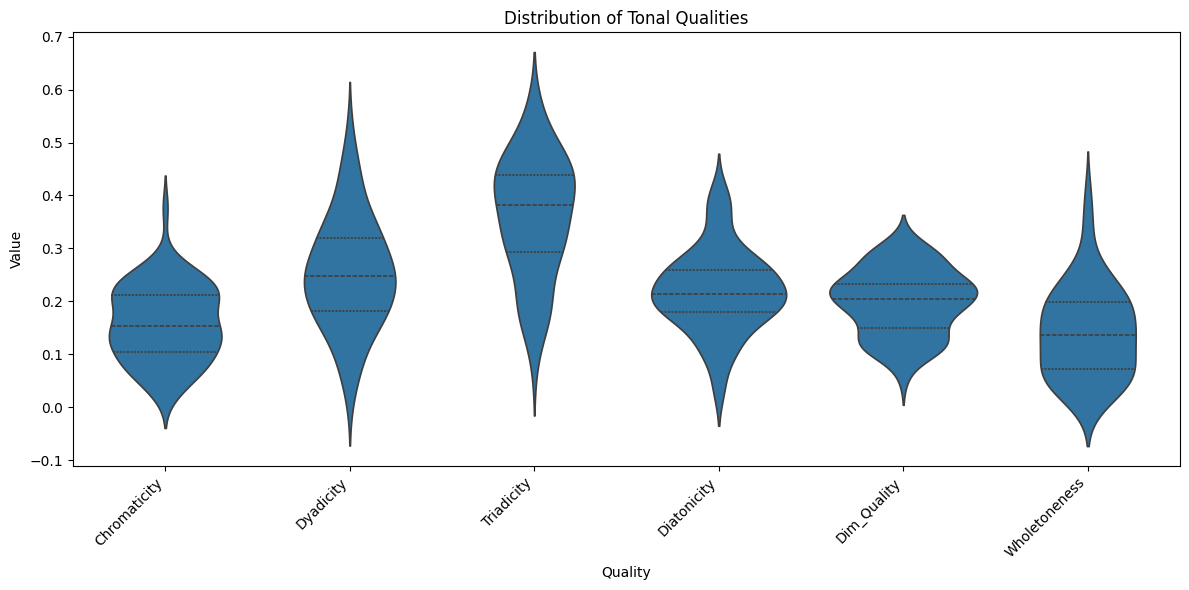

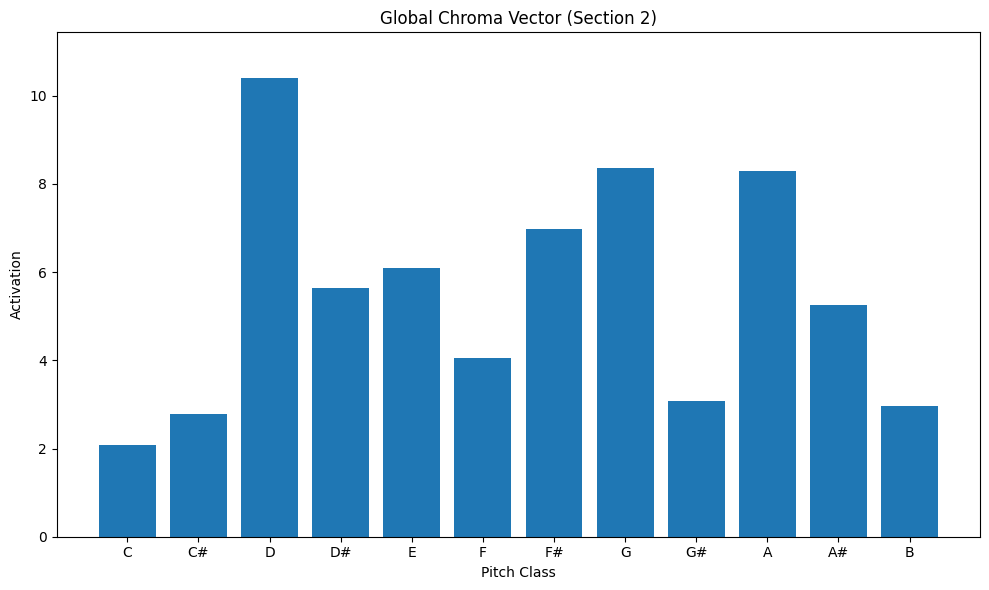

In [33]:
# Violin Plot of Tonal Qualities

if 'df_qualities' in locals() and not df_qualities.empty:
    qualities_to_plot = [
        'Chromaticity', 'Dyadicity', 'Triadicity', 'Diatonicity',
        'Dim_Quality', 'Wholetoneness']
    qualities_to_plot = [q for q in qualities_to_plot if q in df_qualities.columns]

    if qualities_to_plot:
        df_qualities_melted = df_qualities[qualities_to_plot].melt(var_name='Quality Type', value_name='Value')

        plt.figure(figsize=(12, 6))
        sns.violinplot(x='Quality Type', y='Value', data=df_qualities_melted, inner='quartile')
        plt.title('Distribution of Tonal Qualities')
        plt.ylabel('Value')
        plt.xlabel('Quality')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig("saved_plots/plot_4.pdf", bbox_inches="tight")
        plt.show()
    else:
        print("None of the specified quality columns were found in df_qualities.")
else:
    print("df_qualities not found or is empty.")


# Bar Plot of Global Chroma (Section 2)
if 'global_chroma_beats_sec2' in locals() and global_chroma_beats_sec2 is not None:
    chroma_vector = np.asarray(global_chroma_beats_sec2)
    if chroma_vector.size == 12:
        chroma_labels = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

        plt.figure(figsize=(10, 6))
        plt.bar(chroma_labels, chroma_vector)
        plt.ylabel('Activation')
        plt.title('Global Chroma Vector (Section 2)')
        plt.xlabel('Pitch Class')
        plt.ylim(0, np.max(chroma_vector) * 1.1)

        plt.tight_layout()
        plt.savefig("saved_plots/plot_5.pdf", bbox_inches="tight")
        plt.show()
    elif chroma_vector.size > 0:
         print(f"Global Chroma vector has size {chroma_vector.size}, expected 12 for bar plot.")
    else:
        print("Global Chroma vector is empty.")
else:
    print("global_chroma_beats_sec2 not found or is None.")

In [34]:
# Tonnetz From Phase Space Visualization

from matplotlib.colors import Normalize, ListedColormap
from matplotlib.collections import LineCollection
import ipywidgets as widgets
from IPython.display import display
import numpy as np # Ensure numpy is imported here if needed


# Utility
def wrap_angle(x):
    """Wrap angles to [-π, π]."""
    return (x + np.pi) % (2*np.pi) - np.pi


def duplicate_on_borders(x, y, labels, boundary=0.2):
    """Duplicate pitch classes or chords near ±π boundaries."""
    xs, ys, lbls = list(x), list(y), list(labels)
    for xi, yi, li in zip(x, y, labels):
        shifts = []
        if xi > np.pi - boundary:   shifts.append((-2*np.pi, 0))
        if xi < -np.pi + boundary:  shifts.append((+2*np.pi, 0))
        if yi > np.pi - boundary:   shifts.append((0, -2*np.pi))
        if yi < -np.pi + boundary:  shifts.append((0, +2*np.pi))
        if (xi > np.pi - boundary and yi > np.pi - boundary):   shifts.append((-2*2*np.pi, -2*np.pi))
        if (xi > np.pi - boundary and yi < -np.pi + boundary):  shifts.append((-2*np.pi, +2*np.pi))
        if (xi < -np.pi + boundary and yi > np.pi - boundary):  shifts.append((+2*np.pi, -2*np.pi))
        if (xi < -np.pi + boundary and yi < -np.pi + boundary): shifts.append((+2*np.pi, +2*np.pi))
        for dx, dy in shifts:
            xs.append(xi + dx)
            ys.append(yi + dy)
            lbls.append(li)
    return np.array(xs), np.array(ys), lbls


# ------------------------------------------------------------
# Prepare base coordinates and interactive plot setup
# Only proceed if tiv_beats is valid
# ------------------------------------------------------------
if isinstance(tiv_beats, np.ndarray) and tiv_beats.size > 0 and tiv_beats.shape[1] >= 5:
    tiv_vectors_np = tiv_beats

    phase3 = np.angle(tiv_vectors_np[:, 2])  # component 3
    phase5 = np.angle(tiv_vectors_np[:, 4])  # component 5

    chroma_labels = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']

    # --- convert key tuple like ('gb','min') → 'F#'
    def key_to_pitch(key_tuple):
        if not key_tuple or not isinstance(key_tuple, (tuple, list)) or len(key_tuple) == 0:
            return 'C'
        key_name = key_tuple[0].capitalize()
        enharmonics = {
            'Gb': 'F#', 'Db': 'C#', 'Ab': 'G#', 'Eb': 'D#', 'Bb': 'A#',
            'Cb': 'B',  'Fb': 'E'
        }
        return enharmonics.get(key_name, key_name)

    # Ensure key is available; if not, default to 'C'
    center_init = key_to_pitch(globals().get('key_section2', ('C', 'maj')))


    # ------------------------------------------------------------
    # Compute chord reference positions
    # ------------------------------------------------------------
    def chord_positions(intervals, label_func):
        xs, ys, lbls = [], [], []
        for i, label in enumerate(chroma_labels):
            chord_vec = np.zeros(12)
            for interval in intervals:
                chord_vec[(i + interval) % 12] = 1
            tiv_chord = tiv.from_pcp(chord_vec)
            if tiv_chord.vector.shape[0] < 5:
                continue
            x, y = np.angle(tiv_chord.vector[2]), np.angle(tiv_chord.vector[4])
            xs.append(x)
            ys.append(y)
            lbls.append(label_func(label))
        return np.array(xs), np.array(ys), lbls

    base_pc_x, base_pc_y, base_pc_labels = chord_positions([0], lambda l: l)
    base_maj_x, base_maj_y, base_maj_labels = chord_positions([0,4,7], lambda l: l)
    base_min_x, base_min_y, base_min_labels = chord_positions([0,3,7], lambda l: l.lower())


    # ============================================================
    # Interactive Plot Function
    # ============================================================
    def plot_tonnetz(center_pitch, start_beat, end_beat):
        plt.figure(figsize=(8,8))
        plt.xlim([-np.pi-0.1, np.pi+0.1])
        plt.ylim([-np.pi-0.1, np.pi+0.1])
        plt.gca().set_aspect('equal')

        # --- Compute centering offset ---
        idx_center = chroma_labels.index(center_pitch)
        tiv_center = tiv.from_pcp(np.eye(12)[idx_center])
        cx, cy = np.angle(tiv_center.vector[2]), np.angle(tiv_center.vector[4])

        # Pitch classes (with wrapping)
        pcx, pcy, pc_labels = duplicate_on_borders(
            wrap_angle(base_pc_x - cx),
            wrap_angle(base_pc_y - cy),
            base_pc_labels
        )
        majx, majy, maj_labels = duplicate_on_borders(
            wrap_angle(base_maj_x - cx),
            wrap_angle(base_maj_y - cy),
            base_maj_labels
        )
        minx, miny, min_labels = duplicate_on_borders(
            wrap_angle(base_min_x - cx),
            wrap_angle(base_min_y - cy),
            base_min_labels
        )

        # Audio trajectory (recentering and wrapping)
        trajx = wrap_angle(phase3 - cx)
        trajy = wrap_angle(phase5 - cy)

        # --- Plot points ---
        plt.scatter(pcx, pcy, c='red', s=300, marker='o', edgecolors='black', zorder=4)
        for x, y, l in zip(pcx, pcy, pc_labels):
            plt.text(x, y, l, fontsize=8, ha='center', va='center', zorder=5)

        plt.scatter(majx, majy, s=200, c='white', edgecolors='black', marker='s', zorder=6)
        for x, y, l in zip(majx, majy, maj_labels):
            plt.text(x, y, l, fontsize=8, ha='center', va='center', zorder=7)

        plt.scatter(minx, miny, s=200, c='white', edgecolors='black', marker='D', zorder=6)
        for x, y, l in zip(minx, miny, min_labels):
            plt.text(x, y, l, fontsize=8, ha='center', va='center', zorder=7)

        # --- Audio trajectory ---
        plt.scatter(trajx, trajy, alpha=0.5, s=10, zorder=2)
        # Ensure slice indices are within bounds
        start_idx = max(0, min(start_beat, len(trajx) - 1))
        end_idx = max(0, min(end_beat, len(trajx) - 1))

        if start_idx <= end_idx < len(trajx):
             seg_x, seg_y = trajx[start_idx:end_idx+1], trajy[start_idx:end_idx+1]
             if len(seg_x) > 1: # Only plot trajectory if there are at least two points
                 pts = np.array([seg_x, seg_y]).T.reshape(-1, 1, 2)
                 segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
                 norm = Normalize(vmin=start_beat, vmax=end_beat)
                 lc = LineCollection(segs, cmap='viridis', norm=norm, linewidth=2, linestyle='--')
                 lc.set_array(np.arange(start_beat, end_beat))
                 plt.gca().add_collection(lc)


        plt.title(f"Tonnetz Phase Space (center: {center_pitch})")
        plt.xlabel("Phase of Component 3")
        plt.ylabel("Phase of Component 5")
        plt.grid(False)
        plt.savefig("./saved_plots/plot_3.pdf", bbox_inches="tight")
        plt.show()


    # Widgets
    max_beats = len(tiv_beats)
    # Set default values for the first 8 beats (0-indexed)
    start_box = widgets.BoundedIntText(value=0, min=0, max=max_beats-1, step=1, description="Start Beat")
    end_box   = widgets.BoundedIntText(value=min(7, max_beats-1), min=0, max=max_beats-1, step=1, description="End Beat")
    center_box = widgets.Dropdown(options=chroma_labels, value=center_init, description='Center Pitch')

    # Function to update end_box max value when start_box changes
    def update_end_box_max(change):
        start_val = change['new']
        end_box.max = max_beats - 1 # Always allow max_beats - 1 as max possible end
        if end_box.value < start_val:
            end_box.value = start_val # Ensure end is not less than start

    start_box.observe(update_end_box_max, names='value')


    # --- Dropdown de frases (Phrases Dropdown) ---
    # Ensure df_phrases is available and not empty
    if 'df_phrases' in globals() and df_phrases is not None and not df_phrases.empty:
        phrase_labels = df_phrases['Label'].tolist()
        # Add an option to clear phrase selection
        phrase_options = ['Select Phrase'] + phrase_labels
        phrase_dropdown = widgets.Dropdown(options=phrase_options, description='Phrase')

        # Function to find beat indices
        def find_beat_indices(initial_time, duration, beat_times):
            # Find the beat index closest to the initial time
            start_idx = np.argmin(np.abs(beat_times - initial_time))
            # Find the beat index closest to the end time (initial + duration)
            end_time = initial_time + duration
            # We want the beat *after* the end time for the interval, so use side='right'
            end_idx = np.searchsorted(beat_times, end_time, side='left')
            # Adjust end_idx to be the last beat index *within* or *at* the end of the interval
            end_idx = max(0, end_idx - 1)
            return start_idx, end_idx


        def on_phrase_change(change):
            label = change['new']
            if label == 'Select Phrase':
                 # Optionally reset to default or do nothing
                 start_box.value = 0
                 end_box.value = min(7, max_beats-1)
                 return

            # Ensure df_phrases is still valid
            if 'df_phrases' in globals() and df_phrases is not None and not df_phrases.empty:
                phrase = df_phrases[df_phrases['Label'] == label].iloc[0]
                # Ensure beat_times is valid before calling find_beat_indices
                if 'beat_times' in globals() and beat_times is not None and len(beat_times) > 1:
                    start_idx, end_idx = find_beat_indices(phrase['Initial_Time'], phrase['Duration'], beat_times)
                    # Ensure indices are within the valid range of tiv_beats indices
                    start_box.value = max(0, min(start_idx, max_beats - 1))
                    end_box.value = max(0, min(end_idx, max_beats - 1))


        phrase_dropdown.observe(on_phrase_change, names='value')

        ui = widgets.VBox([
            widgets.HBox([center_box, start_box, end_box]),
            phrase_dropdown
        ])
    else:
        # If no phrases, just display the other widgets
        ui = widgets.HBox([center_box, start_box, end_box])
        print("Warning: Phrase data not available. Phrase dropdown not displayed.")


    # Interactive Output
    out = widgets.interactive_output(plot_tonnetz, {
        'center_pitch': center_box,
        'start_beat': start_box,
        'end_beat': end_box
    })

    # Display Interface
    display(ui, out)

else:
    print("Error: tiv_beats not found, is empty, or does not have enough components to plot Tonnetz.")

Output()

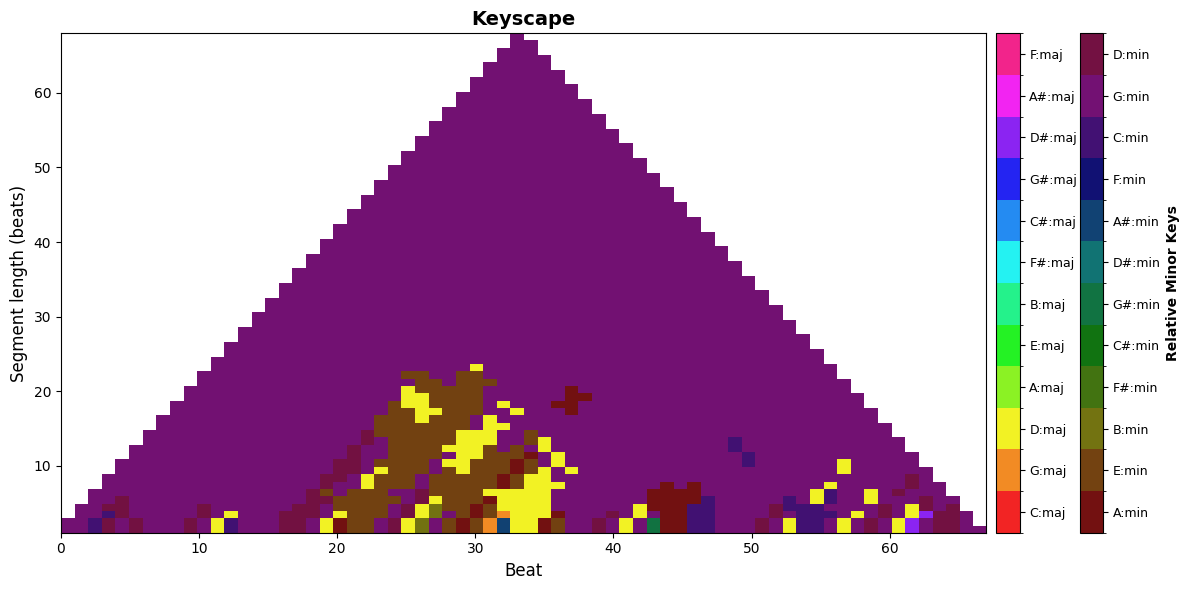

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import colorsys
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter

# Circle of fifths ordering
circle_maj = ["C:maj", "G:maj", "D:maj", "A:maj", "E:maj", "B:maj",
              "F#:maj", "C#:maj", "G#:maj", "D#:maj", "A#:maj", "F:maj"]
circle_min = ["A:min", "E:min", "B:min", "F#:min", "C#:min", "G#:min",
              "D#:min", "A#:min", "F:min", "C:min", "G:min", "D:min"]

circle_keys = circle_maj + circle_min
key_to_idx = {k: i for i, k in enumerate(circle_keys)}
idx_to_key = {i: k for k, i in key_to_idx.items()}

# Enharmonic normalization
ENHARMONIC_FLAT_TO_SHARP = {
    'Cb': 'B',  'Db': 'C#', 'Eb': 'D#', 'Fb': 'E',
    'Gb': 'F#', 'Ab': 'G#', 'Bb': 'A#'
}
ENHARMONIC_OTHER = {'B#': 'C', 'E#': 'F'}

def canonical_tonic(raw):
    if raw is None:
        return None
    s = str(raw).strip().replace('♭', 'b').replace('♯', '#')
    root = s[0].upper()
    acc = s[1:] if len(s) > 1 else ''
    acc = acc.replace('B', 'b') if acc.lower() == 'b' else acc
    tonic = root + acc
    if tonic in ENHARMONIC_FLAT_TO_SHARP:
        return ENHARMONIC_FLAT_TO_SHARP[tonic]
    if tonic in ENHARMONIC_OTHER:
        return ENHARMONIC_OTHER[tonic]
    if len(tonic) == 2 and tonic[1] in ('#', 'b'):
        return tonic[0] + tonic[1]
    return tonic

def canonical_quality(raw_q):
    if raw_q is None:
        return None
    s = str(raw_q).strip().lower()
    if s in ('maj', 'major', 'mjr', 'ma'):
        return 'maj'
    if s in ('min', 'minor', 'm', 'mi'):
        return 'min'
    if s.startswith('m'):
        return 'min'
    return 'maj'

def normalize_key_output(raw):
    if raw is None:
        return None
    tonic = None
    quality = None
    if isinstance(raw, (list, tuple)):
        if len(raw) >= 1:
            tonic = raw[0]
        if len(raw) >= 2:
            quality = raw[1]
    elif isinstance(raw, dict):
        tonic = raw.get('tonic') or raw.get('key') or raw.get('root') or raw.get('label') or raw.get('name')
        quality = raw.get('quality') or raw.get('mode') or raw.get('type') or raw.get('label_mode')
    else:
        s = str(raw).strip()
        if ':' in s:
            tonic, quality = s.split(':', 1)
        elif ' ' in s:
            tonic, quality = s.split(None, 1)
        else:
            tonic = s
    tonic_c = canonical_tonic(tonic)
    quality_c = canonical_quality(quality)
    if tonic_c is None or quality_c is None:
        return None
    return f"{tonic_c}:{quality_c}"

def infer_and_normalize_keys(tiv_beats_objs, mode="temperley", verbose=False):
    normalized = []
    for i, t in enumerate(tiv_beats_objs):
        try:
            raw = t.key(mode=mode)
        except Exception as e:
            if verbose:
                print(f"Beat {i}: ERROR calling .key(): {e}")
            normalized.append(None)
            continue
        nk = normalize_key_output(raw)
        if verbose:
            print(f"Beat {i}: raw={raw} -> normalized={nk}")
        normalized.append(nk)
    return normalized

def compute_keyscape_from_keyseq(key_seq):
    N = len(key_seq)
    scape_matrix = np.full((N, N), np.nan)
    lengths = np.arange(1, N + 1)
    centers = np.arange(N)
    for s in range(N):
        for t in range(s, N):
            length = t - s + 1
            center = (s + t) // 2
            segment = key_seq[s:t+1]
            valid = [k for k in segment if (k is not None and k in key_to_idx)]
            if not valid:
                continue
            cnt = Counter(valid)
            best_key = cnt.most_common(1)[0][0]
            scape_matrix[length-1, center] = key_to_idx[best_key]
    return scape_matrix, centers, lengths

def make_major_minor_colors(major_brightness=0.95, minor_brightness=0.45):
    major_colors = []
    minor_colors = []
    for i in range(12):
        hue = i / 12.0
        r_maj, g_maj, b_maj = colorsys.hsv_to_rgb(hue, 0.85, major_brightness)
        major_colors.append([r_maj, g_maj, b_maj, 1.0])
        r_min, g_min, b_min = colorsys.hsv_to_rgb(hue, 0.85, minor_brightness)
        minor_colors.append([r_min, g_min, b_min, 1.0])
    return major_colors, minor_colors

def make_full_cmap(major_colors, minor_colors):
    return ListedColormap(major_colors + minor_colors)

def plot_keyscape_circle(scape_matrix, centers, lengths, fname=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    scape_masked = np.ma.masked_invalid(scape_matrix)
    major_colors, minor_colors = make_major_minor_colors()
    cmap = make_full_cmap(major_colors, minor_colors)
    im = ax.imshow(scape_masked, origin='lower', aspect='auto',
                   extent=[centers[0], centers[-1], lengths[0], lengths[-1]],
                   cmap=cmap, vmin=0, vmax=len(key_to_idx)-1, interpolation='nearest')
    ax.set_xlabel("Beat", fontsize=12)
    ax.set_ylabel("Segment length (beats)", fontsize=12)
    ax.set_title("Keyscape", fontsize=14, fontweight='bold')
    divider = make_axes_locatable(ax)
    cax_major = divider.append_axes("right", size="2.5%", pad=0.1)
    cax_minor = divider.append_axes("right", size="2.5%", pad=0.6)
    maj_cmap = ListedColormap(major_colors)
    norm_major = plt.matplotlib.colors.BoundaryNorm(np.arange(13) - 0.5, 12)
    cb_major = plt.colorbar(plt.cm.ScalarMappable(norm=norm_major, cmap=maj_cmap),
                            cax=cax_major, ticks=np.arange(12))
    cb_major.ax.set_yticklabels(circle_maj, fontsize=9)
    cb_major.set_label("Major Keys", fontsize=10, fontweight='bold')
    min_cmap = ListedColormap(minor_colors)
    norm_minor = plt.matplotlib.colors.BoundaryNorm(np.arange(13) - 0.5, 12)
    cb_minor = plt.colorbar(plt.cm.ScalarMappable(norm=norm_minor, cmap=min_cmap),
                            cax=cax_minor, ticks=np.arange(12))
    cb_minor.ax.set_yticklabels(circle_min, fontsize=9)
    cb_minor.set_label("Relative Minor Keys", fontsize=10, fontweight='bold')
    plt.tight_layout()
    if fname:
        plt.savefig(fname, bbox_inches="tight", dpi=150)
    plt.show()

# 1. Inferir e normalizar as tonalidades
key_seq = infer_and_normalize_keys(tiv_beats_objs, mode="temperley", verbose=False)

# 2. Calcular a matriz Keyscape
scape_matrix, centers, lengths = compute_keyscape_from_keyseq(key_seq)

# 3. Visualizar
plot_keyscape_circle(scape_matrix, centers, lengths, fname="saved_plots/plot_2.pdf")

## 12) Audios

In [17]:
audio_output = False

# Create multiple audio displays
if audio_output:
  # Display song
  print("Original Song:")
  display(Audio(y_full, rate=sr))

  # Display original vocals
  print("Original Vocals:")
  display(Audio(y_vocals, rate=sr))

  # Display original guitars
  print("\nOriginal Guitars:")
  display(Audio(y_guitars, rate=sr))

  # Display harmonic component of guitars
  print("\nHarmonic Component of Guitars:")
  display(Audio(y_harmonic, rate=sr))

  # Display percussive component of guitars
  print("\nPercussive Component of Guitars:")
  display(Audio(y_percussive, rate=sr))

  # Prepare audio with clicks

  # Create a click sound
  click_duration = 0.01  # seconds
  click_frequency = 1000  # Hz
  click_samples = int(click_duration * sr)
  click_wave = 0.5 * np.sin(2 * np.pi * click_frequency * np.linspace(0, click_duration, click_samples, endpoint=False))
  click_amplitude = 0.5 # Use a consistent amplitude

  def add_clicks_to_audio(y_audio, peak_times, sr, click_wave, click_amplitude):
      """Adds clicks to an audio signal at specified peak times."""
      clicks_audio = np.zeros_like(y_audio)
      for peak_time in peak_times:
          peak_sample = int(peak_time * sr)
          start_sample = peak_sample
          end_sample = min(len(clicks_audio), start_sample + len(click_wave))
          if start_sample < end_sample:
              clicks_audio[start_sample:end_sample] += click_wave[0:end_sample-start_sample] * click_amplitude
      return y_audio + clicks_audio

  # Display vocals with onset clicks
  if 'onsets' in globals() and 'Vocals' in onsets and 'peak_times' in onsets['Vocals']:
      print("\nVocals with Onset Clicks:")
      mixed_vocals_clicks = add_clicks_to_audio(y_vocals, onsets['Vocals']['peak_times'], sr, click_wave, click_amplitude)
      mixed_vocals_clicks = mixed_vocals_clicks / np.max(np.abs(mixed_vocals_clicks)) # Normalize
      display(Audio(mixed_vocals_clicks, rate=sr))
  else:
      print("\nVocals onsets not available.")


  # Display guitars with onset clicks
  if 'onsets' in globals() and 'Guitars' in onsets and 'peak_times' in onsets['Guitars']:
      print("\nGuitars with Onset Clicks:")
      # Use onsets['Guitars']['peak_times'] for guitar onsets
      mixed_guitars_clicks = add_clicks_to_audio(y_guitars, onsets['Guitars']['peak_times'], sr, click_wave, click_amplitude)
      mixed_guitars_clicks = mixed_guitars_clicks / np.max(np.abs(mixed_guitars_clicks)) # Normalize
      display(Audio(mixed_guitars_clicks, rate=sr))
  else:
      print("\nGuitars onsets not available.")

# Evaluation pipeline

## 1) Ground-truth Chromas and TIVs

In [18]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks


# --- Chord to Chroma Mapping ---
chroma_mapping = {
    'C': 0, 'C#': 1, 'Db': 1, 'D': 2, 'D#': 3, 'Eb': 3, 'E': 4, 'F': 5,
    'F#': 6, 'Gb': 6, 'G': 7, 'G#': 8, 'Ab': 8, 'A': 9, 'A#': 10, 'Bb': 10, 'B': 11,
    'N': -1
}

# Pitch class distributions
quality_patterns = {
    'maj': np.array([1,0,0,0,1,0,0,1,0,0,0,0]),
    'min': np.array([1,0,0,1,0,0,0,1,0,0,0,0]),
    '7': np.array([1,0,0,0,1,0,0,1,0,0,1,0]),
    'maj7': np.array([1,0,0,0,1,0,0,1,0,0,0,1]),
    'min7': np.array([1,0,0,1,0,0,0,1,0,0,1,0]),
    'dim': np.array([1,0,0,1,0,0,1,0,0,0,0,0]),
    'dim7': np.array([1,0,0,1,0,0,1,0,0,1,0,0]),
    'aug': np.array([1,0,0,0,1,0,0,0,1,0,0,0]),
    'sus2': np.array([1,0,1,0,0,0,0,1,0,0,0,0]),
    'sus4': np.array([1,0,0,0,0,1,0,1,0,0,0,0]),
    'maj6': np.array([1,0,0,0,1,0,0,1,0,0,0,1]),
    'min6': np.array([1,0,0,1,0,0,0,1,0,0,0,1]),
    'maj7b5': np.array([1,0,0,0,1,0,1,0,0,0,0,1]),
    '': np.array([1,0,0,0,0,0,0,0,0,0,0,0])
}

def chord_label_to_chroma(label: str) -> np.ndarray:
    if label == 'N':
        return np.zeros(12)
    parts = label.strip().split()
    root_label = parts[0] if parts else ''
    quality_str = " ".join(parts[1:]) if len(parts) > 1 else ''
    root_idx = chroma_mapping.get(root_label, -1)
    pattern = quality_patterns.get(quality_str.lower(), quality_patterns[''])
    return np.roll(pattern, root_idx) if root_idx != -1 else np.zeros(12)

# --- Ground Truth Chromagrams ---
chord_intervals = np.append(chord_times_seconds, chord_times_seconds[-1] + 10.0)
n_frames = int(len(y_full) / hop_length) + 1
frame_times = librosa.frames_to_time(np.arange(n_frames), sr=sr, hop_length=hop_length)
ground_truth_chroma_framewise = np.zeros((12, n_frames))
for i, t in enumerate(frame_times):
    idx = np.searchsorted(chord_intervals, t, side='right') - 1
    if 0 <= idx < len(chord_types):
        ground_truth_chroma_framewise[:, i] = chord_label_to_chroma(chord_types[idx])

n_beats = len(beat_times) - 1
ground_truth_chroma_beatsync = np.zeros((12, n_beats))
for b in range(n_beats):
    mid_time = 0.5 * (beat_times[b] + beat_times[b+1])
    idx = np.searchsorted(chord_intervals, mid_time, side='right') - 1
    if 0 <= idx < len(chord_types):
        ground_truth_chroma_beatsync[:, b] = chord_label_to_chroma(chord_types[idx])

# Section-Specific (2) Global Chroma
sec_row = df_sections.iloc[1]
sec_start, sec_end = sec_row['Initial_Time'], sec_row['Initial_Time'] + sec_row['Duration']
mask_frames = (frame_times >= sec_start) & (frame_times < sec_end)
global_chroma_frames_gt = np.sum(ground_truth_chroma_framewise[:, mask_frames], axis=1) if mask_frames.any() else None
beat_times_eff = beat_times[:ground_truth_chroma_beatsync.shape[1]]
mask_beats = (beat_times_eff >= sec_start) & (beat_times_eff < sec_end)
global_chroma_beats_gt = np.sum(ground_truth_chroma_beatsync[:, mask_beats], axis=1) if mask_beats.any() else None

# Global TIV, Tonal Dispersion, Dissonance
if ground_truth_chroma_beatsync is not None and ground_truth_chroma_beatsync.size > 0:
    ground_truth_tiv_list = []
    for i in range(ground_truth_chroma_beatsync.shape[1]):
        try:
            tiv_vec = tiv.from_pcp(ground_truth_chroma_beatsync[:, i], data_type='symbolic')
            ground_truth_tiv_list.append(tiv_vec)
        except:
            continue
    global_chroma_gt = np.sum(ground_truth_chroma_beatsync, axis=1)
    try:
        global_tiv_gt = tiv.from_pcp(global_chroma_gt)
    except:
        global_tiv_gt = None

    tonal_disp_gt = [
        cosine_distance_complex(global_tiv_gt.vector, vec.vector)
        for vec in ground_truth_tiv_list
    ] if global_tiv_gt else [np.nan] * len(ground_truth_tiv_list)

    quality_data_gt = []
    for vec, disp in zip(ground_truth_tiv_list, tonal_disp_gt):
        quality_data_gt.append({
            'Chromaticity_GT': vec.chromaticity(),
            'Diatonicity_GT': vec.diatonicity(),
            'Dyadicity_GT': vec.dyadicity(),
            'Triadicity_GT': vec.triadicity(),
            'Dim_Quality_GT': vec.dim_quality(),
            'Wholetoneness_GT': vec.wholetoneness(),
            'Dissonance_GT': vec.dissonance(),
            'Tonal_Dispersion_GT': disp
        })

    df_qualities_gt = pd.DataFrame(quality_data_gt)
    tonal_disp_gt = df_qualities_gt['Tonal_Dispersion_GT'].to_numpy()
    dissonance_gt = df_qualities_gt['Dissonance_GT'].to_numpy()

# Ground Truth HCF Computation
def compute_ground_truth_hcf_from_chroma(chroma, method):
    if chroma is None or chroma.size == 0:
        return np.array([]), np.array([])

    # Convert chroma to TIVs
    tiv_list = [tiv.from_pcp(chroma[:, i], data_type='symbolic') for i in range(chroma.shape[1])]
    tiv_matrix = np.array([t.vector for t in tiv_list]).T  # shape: (dim, time)

    # Compute raw HCF using same method as audio
    hcf_raw = hcf_raw_from_tivs(tiv_matrix, method)

    return hcf_raw

# Beat-synchronous ground truth HCF
ground_truth_hcf_beats_raw = compute_ground_truth_hcf_from_chroma(
    chroma=ground_truth_chroma_beatsync,
    method=hcf_method
)

# Framewise ground truth HCF
ground_truth_hcf_frames = compute_ground_truth_hcf_from_chroma(
    chroma=ground_truth_chroma_framewise,
    method=hcf_method
)

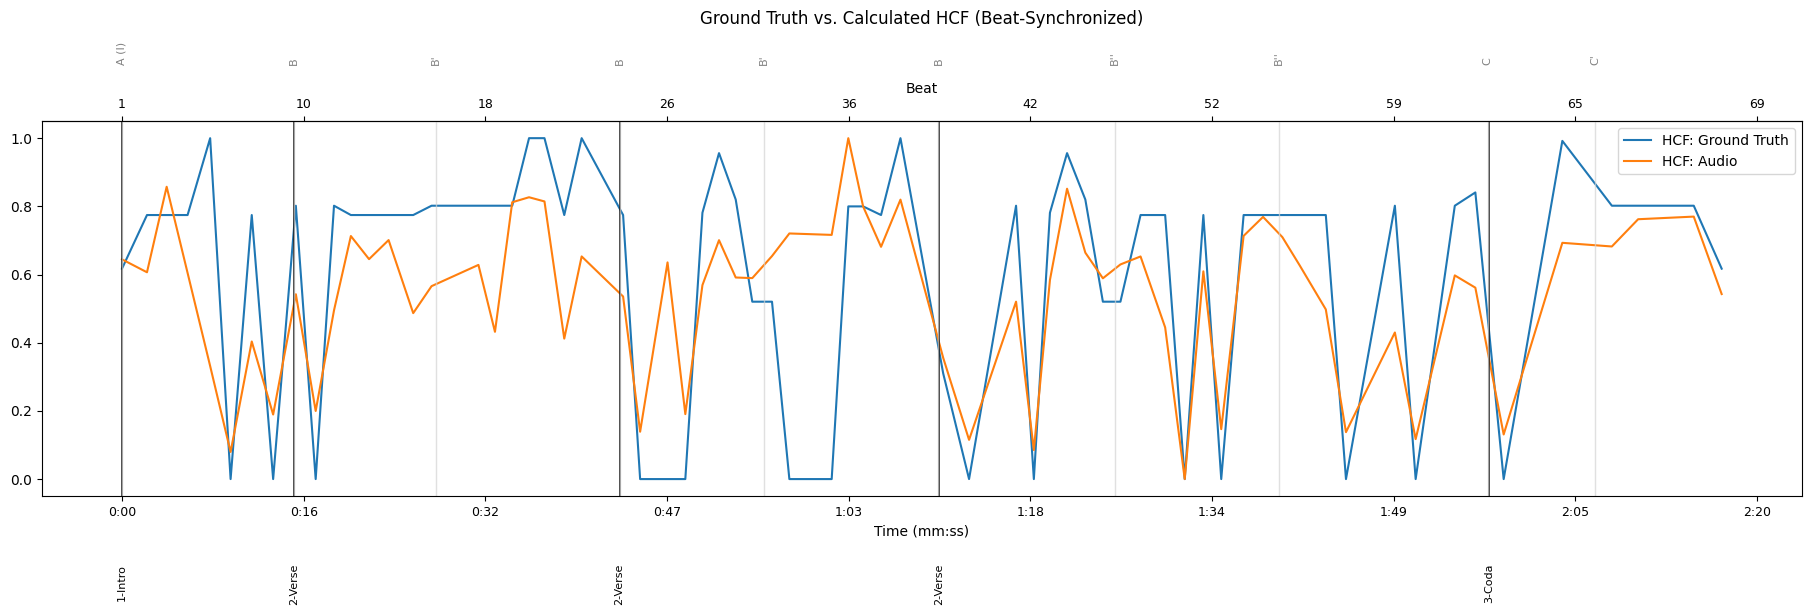

Beat-Synchronized HCF:
Pearson Correlation Coefficient (R): 0.7172
R-squared (R^2): 0.5144
P-value: 0.0000
--------------------
Beat-Synchronized HCF:
Pearson Correlation Coefficient (R): 0.7172
R-squared (R^2): 0.5144
P-value: 0.0000
--------------------


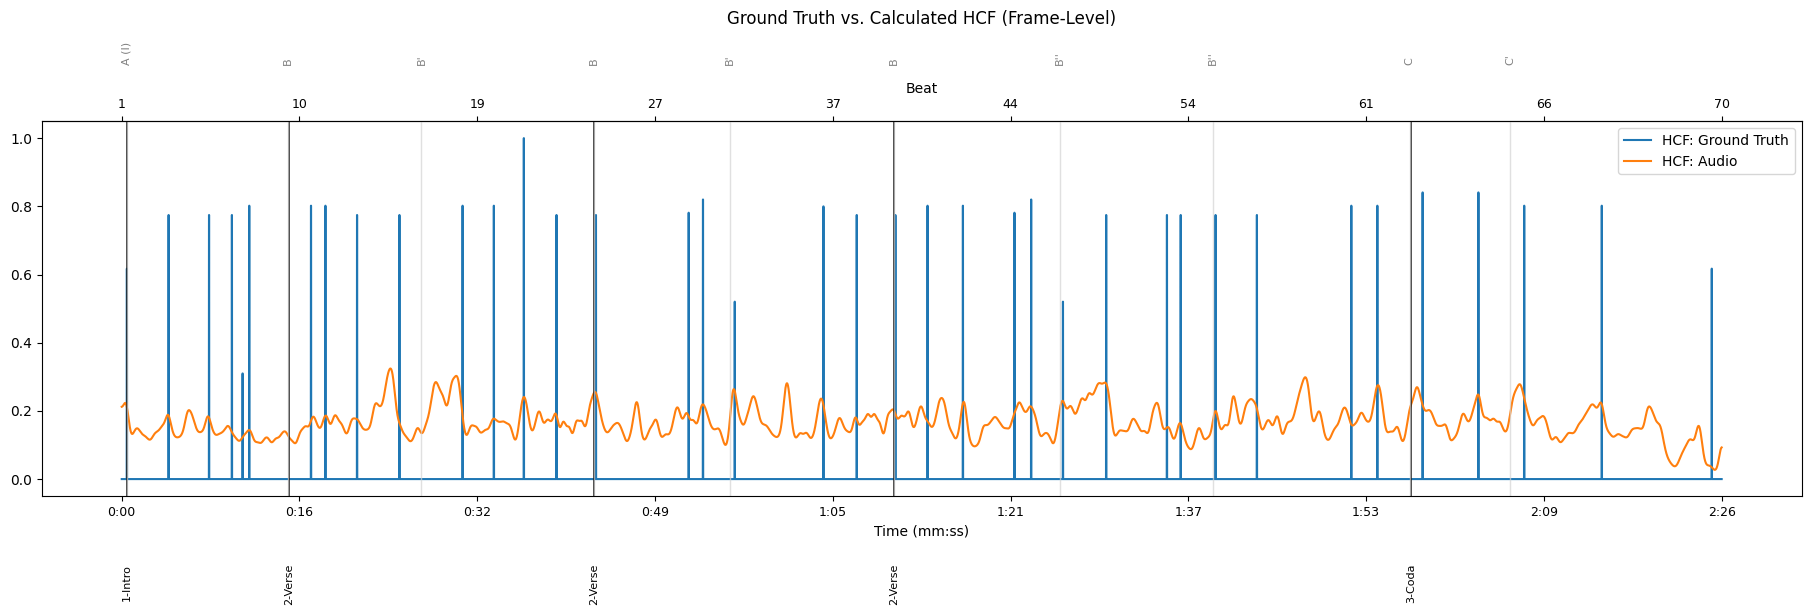

Frame-Level HCF:
Pearson Correlation Coefficient (R): 0.0306
R-squared (R^2): 0.0009
P-value: 0.0006
--------------------
Frame-Level HCF:
Pearson Correlation Coefficient (R): 0.0306
R-squared (R^2): 0.0009
P-value: 0.0006


In [19]:
from scipy.stats import pearsonr

# Plotting HCF (Beat-Synchronized)
plot([
    ('ground_truth_hcf_beats_raw', True, 0, "HCF: Ground Truth"),
    ('hcf_raw_beats', True, 0, "HCF: Audio")
], title="Ground Truth vs. Calculated HCF (Beat-Synchronized)", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=None)

# Compute Pearson correlation and p-value for beat-synchronized HCF
# Ensure both arrays have the same length
corr_beats, p_value_beats = pearsonr(ground_truth_hcf_beats_raw, hcf_raw_beats)
r_squared_beats = corr_beats**2


log_message(f"Beat-Synchronized HCF:")
log_message(f"Pearson Correlation Coefficient (R): {corr_beats:.4f}")
log_message(f"R-squared (R^2): {r_squared_beats:.4f}")
log_message(f"P-value: {p_value_beats:.4f}")
log_message("-" * 20)

print(f"Beat-Synchronized HCF:")
print(f"Pearson Correlation Coefficient (R): {corr_beats:.4f}")
print(f"R-squared (R^2): {r_squared_beats:.4f}")
print(f"P-value: {p_value_beats:.4f}")
print("-" * 20)

# Plotting HCF (Frame-Level)
frame_times_hcf = librosa.frames_to_time(np.arange(len(hcf_raw_frames)), sr=sr, hop_length=hop_length)

plot([
    ('ground_truth_hcf_frames', True, 0, "HCF: Ground Truth"),
    ('hcf_raw_frames', True, 20, "HCF: Audio")
], title="Ground Truth vs. Calculated HCF (Frame-Level)", x_axis=frame_times_hcf, df_sections=df_sections, df_phrases=df_phrases, mode="time", plot_index=None)


# Compute Pearson correlation and p-value for frame-level HCF
corr_frames, p_value_frames = pearsonr(ground_truth_hcf_frames, hcf_raw_frames)
r_squared_frames = corr_frames**2

log_message(f"Frame-Level HCF:")
log_message(f"Pearson Correlation Coefficient (R): {corr_frames:.4f}")
log_message(f"R-squared (R^2): {r_squared_frames:.4f}")
log_message(f"P-value: {p_value_frames:.4f}")
log_message("-" * 20)

print(f"Frame-Level HCF:")
print(f"Pearson Correlation Coefficient (R): {corr_frames:.4f}")
print(f"R-squared (R^2): {r_squared_frames:.4f}")
print(f"P-value: {p_value_frames:.4f}")

/tmp/ipython-input-3814435576.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust tight_layout to make space for the colorbar


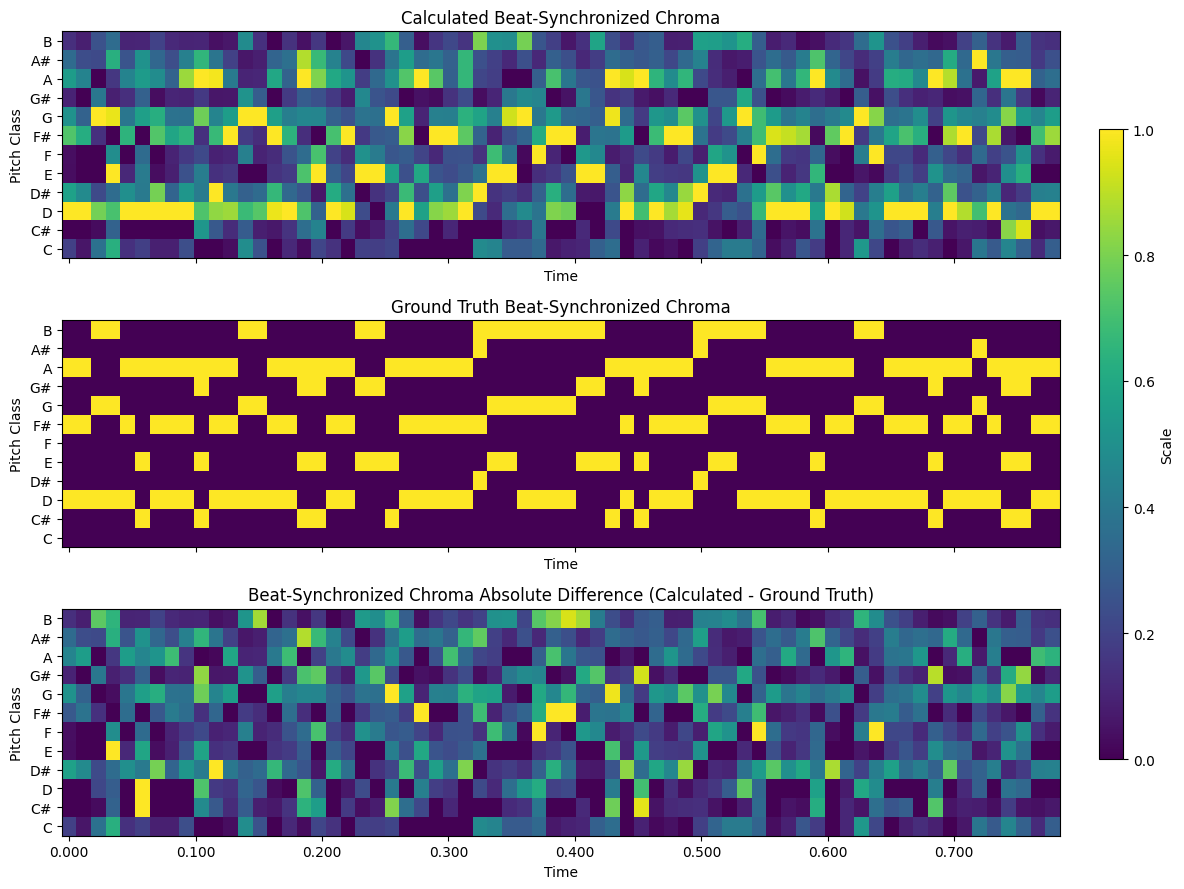

Beat-Synchronized Chroma Comparison:
Pearson Correlation Coefficient (R): 0.6197
R-squared (R^2): 0.3840
P-value: 0.0000
Sum of Absolute Differences: 219.0835
Sum of Squared Differences: 105.4941
--------------------
Beat-Synchronized Chroma Comparison:
Pearson Correlation Coefficient (R): 0.6197
R-squared (R^2): 0.3840
P-value: 0.0000
Sum of Absolute Differences: 219.0835
Sum of Squared Differences: 105.4941


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
from scipy.stats import pearsonr

# Ensure chromas have the same length (should be n_beats)
min_len_chroma = min(chroma_beats.shape[1], ground_truth_chroma_beatsync.shape[1])
chroma_beats_sync = chroma_beats[:, :min_len_chroma]
ground_truth_chroma_beatsync_sync = ground_truth_chroma_beatsync[:, :min_len_chroma]

# Calculate the difference
chroma_difference = chroma_beats_sync - ground_truth_chroma_beatsync_sync
chroma_absolute_difference = np.abs(chroma_difference)

# Determine the min and max values across all chromas for consistent color scaling
# For 'viridis' which is good for magnitudes, we can set vmin to 0
vmin = 0
vmax = max(chroma_beats_sync.max(), ground_truth_chroma_beatsync_sync.max(), chroma_absolute_difference.max())


# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Plot Calculated Chroma
librosa.display.specshow(chroma_beats_sync, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma', ax=axes[0], cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title('Calculated Beat-Synchronized Chroma')
axes[0].set_ylabel('Pitch Class')
axes[0].set_yticks(np.arange(12))
axes[0].set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])


# Plot Ground Truth Chroma
librosa.display.specshow(ground_truth_chroma_beatsync_sync, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma', ax=axes[1], cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title('Ground Truth Beat-Synchronized Chroma')
axes[1].set_ylabel('Pitch Class')
axes[1].set_yticks(np.arange(12))
axes[1].set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])


# Plot Chroma Difference
img = librosa.display.specshow(chroma_absolute_difference, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma', ax=axes[2], cmap='viridis', vmin=vmin, vmax=vmax)
axes[2].set_title('Beat-Synchronized Chroma Absolute Difference (Calculated - Ground Truth)')
axes[2].set_ylabel('Pitch Class')
axes[2].set_yticks(np.arange(12))
axes[2].set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])

# Add a colorbar axis and create the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
fig.colorbar(img, cax=cbar_ax, label='Scale')


plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust tight_layout to make space for the colorbar
plt.savefig("saved_plots/plot_1.pdf", bbox_inches="tight")
plt.show()

# Compute correlation and sum of differences
# Flatten the arrays for correlation calculation
chroma_beats_flat = chroma_beats_sync.flatten()
ground_truth_chroma_beatsync_flat = ground_truth_chroma_beatsync_sync.flatten()

# Remove NaNs if any (though unlikely for chromas after processing)
mask = np.isfinite(chroma_beats_flat) & np.isfinite(ground_truth_chroma_beatsync_flat)
chroma_beats_flat = chroma_beats_flat[mask]
ground_truth_chroma_beatsync_flat = ground_truth_chroma_beatsync_flat[mask]


correlation_coefficient, p_value = pearsonr(chroma_beats_flat, ground_truth_chroma_beatsync_flat)
r_squared = correlation_coefficient**2

sum_of_absolute_differences = np.sum(np.abs(chroma_difference))
sum_of_squared_differences = np.sum(chroma_difference**2)

log_message(f"Beat-Synchronized Chroma Comparison:")
log_message(f"Pearson Correlation Coefficient (R): {correlation_coefficient:.4f}")
log_message(f"R-squared (R^2): {r_squared:.4f}")
log_message(f"P-value: {p_value:.4f}")
log_message(f"Sum of Absolute Differences: {sum_of_absolute_differences:.4f}")
log_message(f"Sum of Squared Differences: {sum_of_squared_differences:.4f}")
log_message("-" * 20)


print(f"Beat-Synchronized Chroma Comparison:")
print(f"Pearson Correlation Coefficient (R): {correlation_coefficient:.4f}")
print(f"R-squared (R^2): {r_squared:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Sum of Absolute Differences: {sum_of_absolute_differences:.4f}")
print(f"Sum of Squared Differences: {sum_of_squared_differences:.4f}")

## 2) Sensory Dissonance vs. Tonal Dissonance & Tonal Dispersion (audio vs. ground truth)




In [21]:
# Compute STFT once on full audio
S = np.abs(librosa.stft(y_full, n_fft=n_fft, hop_length=hop_length, window=window))
fft_freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# Compute sensory dissonance curve (frame-level)
sens_curve = []
for t in range(S.shape[1]):
    amps = S[:, t]
    if np.all(amps == 0):
        sens_curve.append(0.0)
        continue
    idx = np.argpartition(amps, -N_partials)[-N_partials:] if N_partials < len(amps) else np.arange(len(amps))
    f_frame = fft_freqs[idx]
    a_frame = amps[idx]
    a_frame = a_frame / (np.max(a_frame) + 1e-12)
    try:
        sens_curve.append(dissonance(f_frame, a_frame, model='sethares1993'))
    except Exception:
        sens_curve.append(np.nan)

sens_curve = np.asarray(sens_curve)
frame_t = librosa.frames_to_time(np.arange(S.shape[1]), sr=sr, hop_length=hop_length)

# Apply aggregation to sensory dissonance
sensory_dissonance_beats_raw = aggregate_to_beats(frame_t, sens_curve, beat_times)

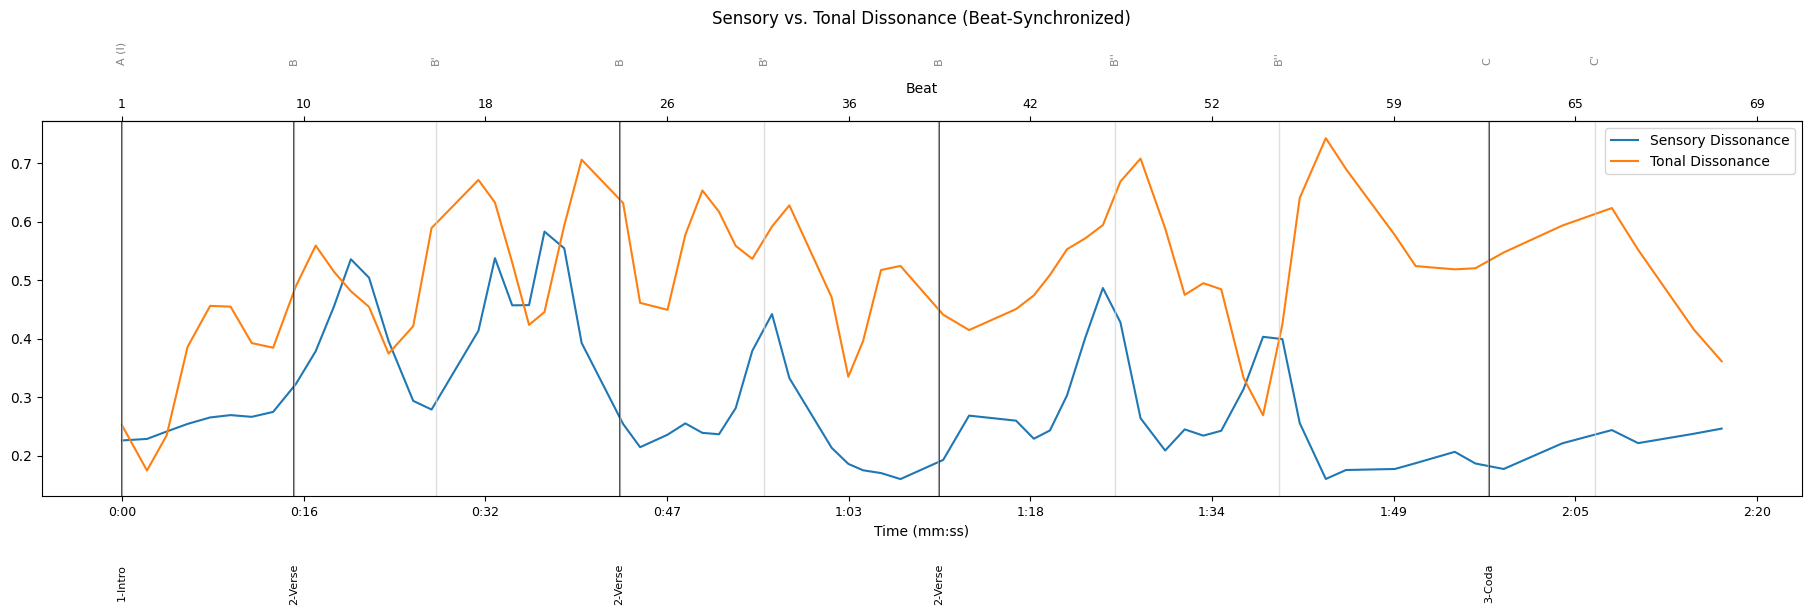

Sensory Dissonance and Tonal Dissonance:
Pearson Correlation Coefficient (R): -0.1053
R-squared (R^2): 0.0111
P-value: 0.3926
--------------------
Pearson Correlation Coefficient (R): -0.1053
R-squared (R^2): 0.0111
P-value: 0.3926


In [22]:
# Plotting the two dissonance measures
plot([
    ('sensory_dissonance_beats_raw', True, 1, "Sensory Dissonance"),
    ('df_qualities["Tonal_Dissonance"]', True, 1, "Tonal Dissonance")
], title="Sensory vs. Tonal Dissonance (Beat-Synchronized)", x_axis=beat_times, df_sections=df_sections, df_phrases=df_phrases, plot_index=None)

# Compute Pearson correlation and p-value
correlation_coefficient, p_value = pearsonr(sensory_dissonance_beats_raw, df_qualities["Tonal_Dissonance"])
r_squared = correlation_coefficient**2

log_message(f"Sensory Dissonance and Tonal Dissonance:")
log_message(f"Pearson Correlation Coefficient (R): {correlation_coefficient:.4f}")
log_message(f"R-squared (R^2): {r_squared:.4f}")
log_message(f"P-value: {p_value:.4f}")
log_message("-" * 20)

print(f"Pearson Correlation Coefficient (R): {correlation_coefficient:.4f}")
print(f"R-squared (R^2): {r_squared:.4f}")
print(f"P-value: {p_value:.4f}")

Tonal Dispersion (Audio vs. Ground Truth):
Pearson Correlation Coefficient (R): 0.8276
R-squared (R^2): 0.6849
P-value: 0.0000
--------------------
Tonal Dispersion (Audio vs. Ground Truth):
Pearson Correlation Coefficient (R): 0.8276
R-squared (R^2): 0.6849
P-value: 0.0000


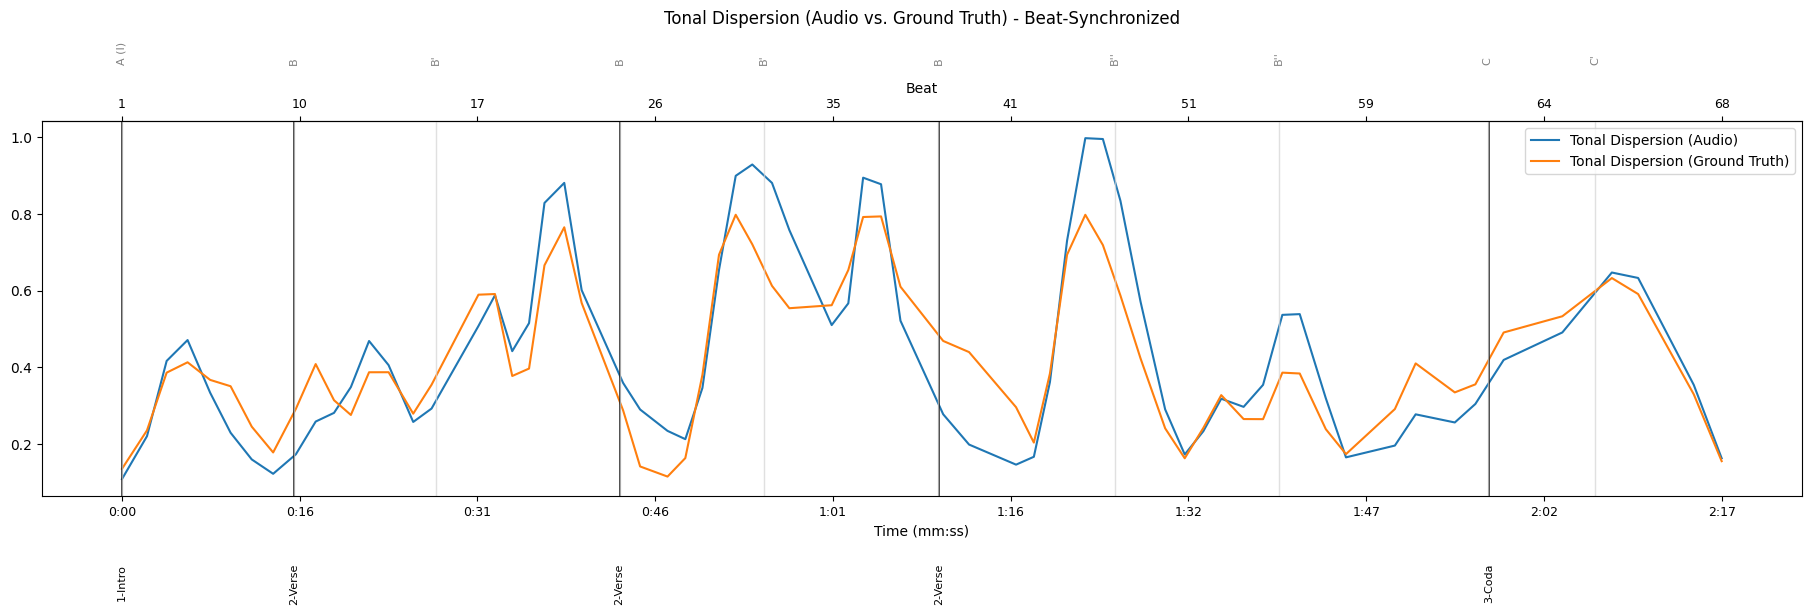

In [23]:
# Ensure both arrays have the same length
min_len_dispersion = min(len(df_qualities['Tonal_Dispersion']), len(df_qualities_gt['Tonal_Dispersion_GT']))
tonal_dispersion_audio_sync = df_qualities['Tonal_Dispersion'].values[:min_len_dispersion]
tonal_dispersion_gt_sync = df_qualities_gt['Tonal_Dispersion_GT'].values[:min_len_dispersion]

# Assign to global variables so plot() can access them via eval()
global_tonal_dispersion_audio_sync = tonal_dispersion_audio_sync
global_tonal_dispersion_gt_sync = tonal_dispersion_gt_sync


# Compute Pearson correlation and p-value
correlation_coefficient_dispersion, p_value_dispersion = pearsonr(global_tonal_dispersion_audio_sync, global_tonal_dispersion_gt_sync)
r_squared_dispersion = correlation_coefficient_dispersion**2

log_message(f"Tonal Dispersion (Audio vs. Ground Truth):")
log_message(f"Pearson Correlation Coefficient (R): {correlation_coefficient_dispersion:.4f}")
log_message(f"R-squared (R^2): {r_squared_dispersion:.4f}")
log_message(f"P-value: {p_value_dispersion:.4f}")
log_message("-" * 20)

print(f"Tonal Dispersion (Audio vs. Ground Truth):")
print(f"Pearson Correlation Coefficient (R): {correlation_coefficient_dispersion:.4f}")
print(f"R-squared (R^2): {r_squared_dispersion:.4f}")
print(f"P-value: {p_value_dispersion:.4f}")

# Plotting the two tonal dispersion measures
# Pass the names of the global variables as strings to plot()
plot([
    ("global_tonal_dispersion_audio_sync", False, 1, "Tonal Dispersion (Audio)"),
    ("global_tonal_dispersion_gt_sync", False, 1, "Tonal Dispersion (Ground Truth)")
], title="Tonal Dispersion (Audio vs. Ground Truth) - Beat-Synchronized", x_axis=beat_times[:min_len_dispersion], df_sections=df_sections, df_phrases=df_phrases, plot_index=None)

# Export Report

In [24]:
# Define project name and safe filename
safe_project_name = PROJECT_NAME.replace('/', '_').replace(' ', '_')
out_pdf = f"{safe_project_name}_Report.pdf"

# Create PDF
pdf = fitz.open()

# Add title page with project name
title_page = pdf.new_page()
title_text = f"Report\nProject: {PROJECT_NAME}"
title_page.insert_textbox(fitz.Rect(50, 50, 550, 200), title_text, fontsize=20, align=1)

# Add log messages (optional)
log_file = "./execution_log.txt"
if os.path.exists(log_file):
    with open(log_file, "r") as f:
        log_text = f.read()
    page = pdf.new_page()
    page.insert_textbox(fitz.Rect(50, 50, 550, 800), log_text, fontsize=11)

# Add plots from directory sequentially
plot_dir = "./saved_plots"
if os.path.exists(plot_dir):
    # Get all pdf and png files
    plot_files = [f for f in os.listdir(plot_dir) if f.endswith(".pdf") or f.endswith(".png")]

    # Sort files numerically based on the plot index
    def sort_key(fname):
        match = re.search(r'plot_(\d+)', fname)
        if match:
            return int(match.group(1))
        return float('inf') # Put files without a clear plot index at the end

    plot_files_sorted = sorted(plot_files, key=sort_key)

    for i, fname in enumerate(plot_files_sorted):
        fpath = os.path.join(plot_dir, fname)
        if fname.endswith(".pdf"):
            try:
                plot_pdf = fitz.open(fpath)
                pdf.insert_pdf(plot_pdf)
                plot_pdf.close() # Close the opened PDF to free resources
            except Exception as e:
                 print(f"Error processing PDF plot {fname}: {e}")
        elif fname.endswith(".png"):
            try:
                img = fitz.open(fpath)
                rect = img[0].rect
                page = pdf.new_page(width=rect.width, height=rect.height)
                page.insert_image(rect, filename=fpath)
                img.close() # Close the opened image to free resources
            except Exception as e:
                print(f"Error processing PNG plot {fname}: {e}")


# Save combined PDF
pdf.save(out_pdf)
print(f"Combined report saved to {out_pdf}")

# Offer to download the file
try:
    files.download(out_pdf)
except Exception as e:
    print(f"Could not initiate download: {e}")
    print(f"You can manually download the file '{out_pdf}' from the file browser.")

Combined report saved to 1967_Luiz_Goes_Canção_da_Infância_Report.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>